## Score-based Generative Modeling

Suppose we want to generate meaningful data from a data distribution $p_{data}(x)$, which is an unknown distribution. Since a probability must integrate to one, we may assume some form on $p_{data}(x)$, such as 
$$
    p_{data}(x) = \dfrac{e^{-f(x)}}{Z}
$$
where $Z$ is a normalization constant such that $\int p_{data}(x)dx = 1$, and $f(x)$ is called the energy (or logits) of the distribution, and $e^{-f(x)}$ ensures non-negative values. This form amplifies the output such that the maxima are more accentuated. In statistical mechanics, this is also called the Boltzmann distribution. In Machine Learning, this is called the softmax (softargmax) output. 

The problem, however, is that it can be expensive to integrate over all possible $e^{-f(x)}$ to obtain $Z$. Therefore, one approach is to look at the gradients $\nabla_x \log p_{data}(x)$ instead, because
\begin{align*}
    \nabla_x \log p_{data}(x) &= \nabla_x \log \dfrac{e^{-f(x)}}{Z}\\
    &= \nabla_x (\log e^{-f(x)} - \log Z)\\
    &= \nabla_x \log e^{-f(x)} - \nabla_x \log Z\\
    &= \nabla_x -f(x) - 0\\
    &= - \nabla_x f(x)\\
\end{align*}

In other words, instead of modeling the data distribution directly, i.e., $p_{data}(x)$, we can instead model the gradient of the log data distribution, i.e., $- \nabla_x f(x)$. The gradient information provides us an indirect way of sampling the data distribution by performing an iterative procedure called Langevin Dynamics. This is analogous to the gradient descent procedure, but we are not descending with respect to the parameters of a network, but with respect to the input $x$ that we want to generate. 

Given an initial value from a prior distribution $x_0 \sim \pi(x) = \mathcal{N}(0, 1)$ and a step size $\epsilon > 0$, we apply Langevin dynamics recursively for $t=[1,2,\dots,T]$ steps
$$
    x_t = x_{t-1} + \epsilon \nabla_x \log p_{data}(x_{t-1}) + \sqrt{2\epsilon} \;z_t
$$

where $z_t \sim \mathcal{N}(0, 1)$. After $T$ steps, $x_T \sim p_{data}(x)$. 

Now we want to create a model to approximate $\nabla_x \log p_{data}(x) = - \nabla_x f(x) \approx s_{\theta}(x)$. The function $s_{\theta}(x)$ is called the score function, which we can estimate with a neural network. We actually condition the score function on the time step, since it makes 

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

## Example: gradient ascent

In [50]:
def multivariate_gaussian(x, mean, cov):
    return 1/((2*torch.pi)**(cov.shape[0]/2) * torch.det(cov)**.5 ) * torch.exp(-.5 * (x-mean).T @ torch.pinverse(cov) @ (x-mean))

# normal = lambda x, mu, cov: (1/((2*np.pi)**(cov.shape[0]/2) * np.linalg.det(cov)**0.5)) * np.exp(-0.5 * (x-mu).T @ np.linalg.pinv(cov) @ (x-mu))

x_range = torch.linspace(-4, 4, 60)
xx, yy = torch.meshgrid(x_range, x_range)

X = torch.vstack((xx.flatten(), yy.flatten())).T

pi_1 = 0.8
pi_2 = 0.6

mu_1 = torch.tensor([[2], [-2]])
mu_2 = torch.tensor([[0], [2]])

cov_1 = torch.tensor([
    [5., 1.],
    [1., 5.]
])
cov_2 = torch.tensor([
    [4, 3.],
    [3., 5]
])

p_data = lambda x: (pi_1 * multivariate_gaussian(x[..., None], mu_1, cov_1) + pi_2 * multivariate_gaussian(x[..., None], mu_2, cov_2)).flatten()

p_X = torch.vstack([p_data(x) for x in X])

tau = 0.2

path = []
x_current = torch.tensor([-2., -2.], requires_grad=True)

for i in range(80):
    
    x_current.grad = None
    log_p_x = p_data(x_current).log()
    log_p_x.backward()
    with torch.no_grad():
        x_current += tau * x_current.grad
        path.append(x_current.clone().detach())

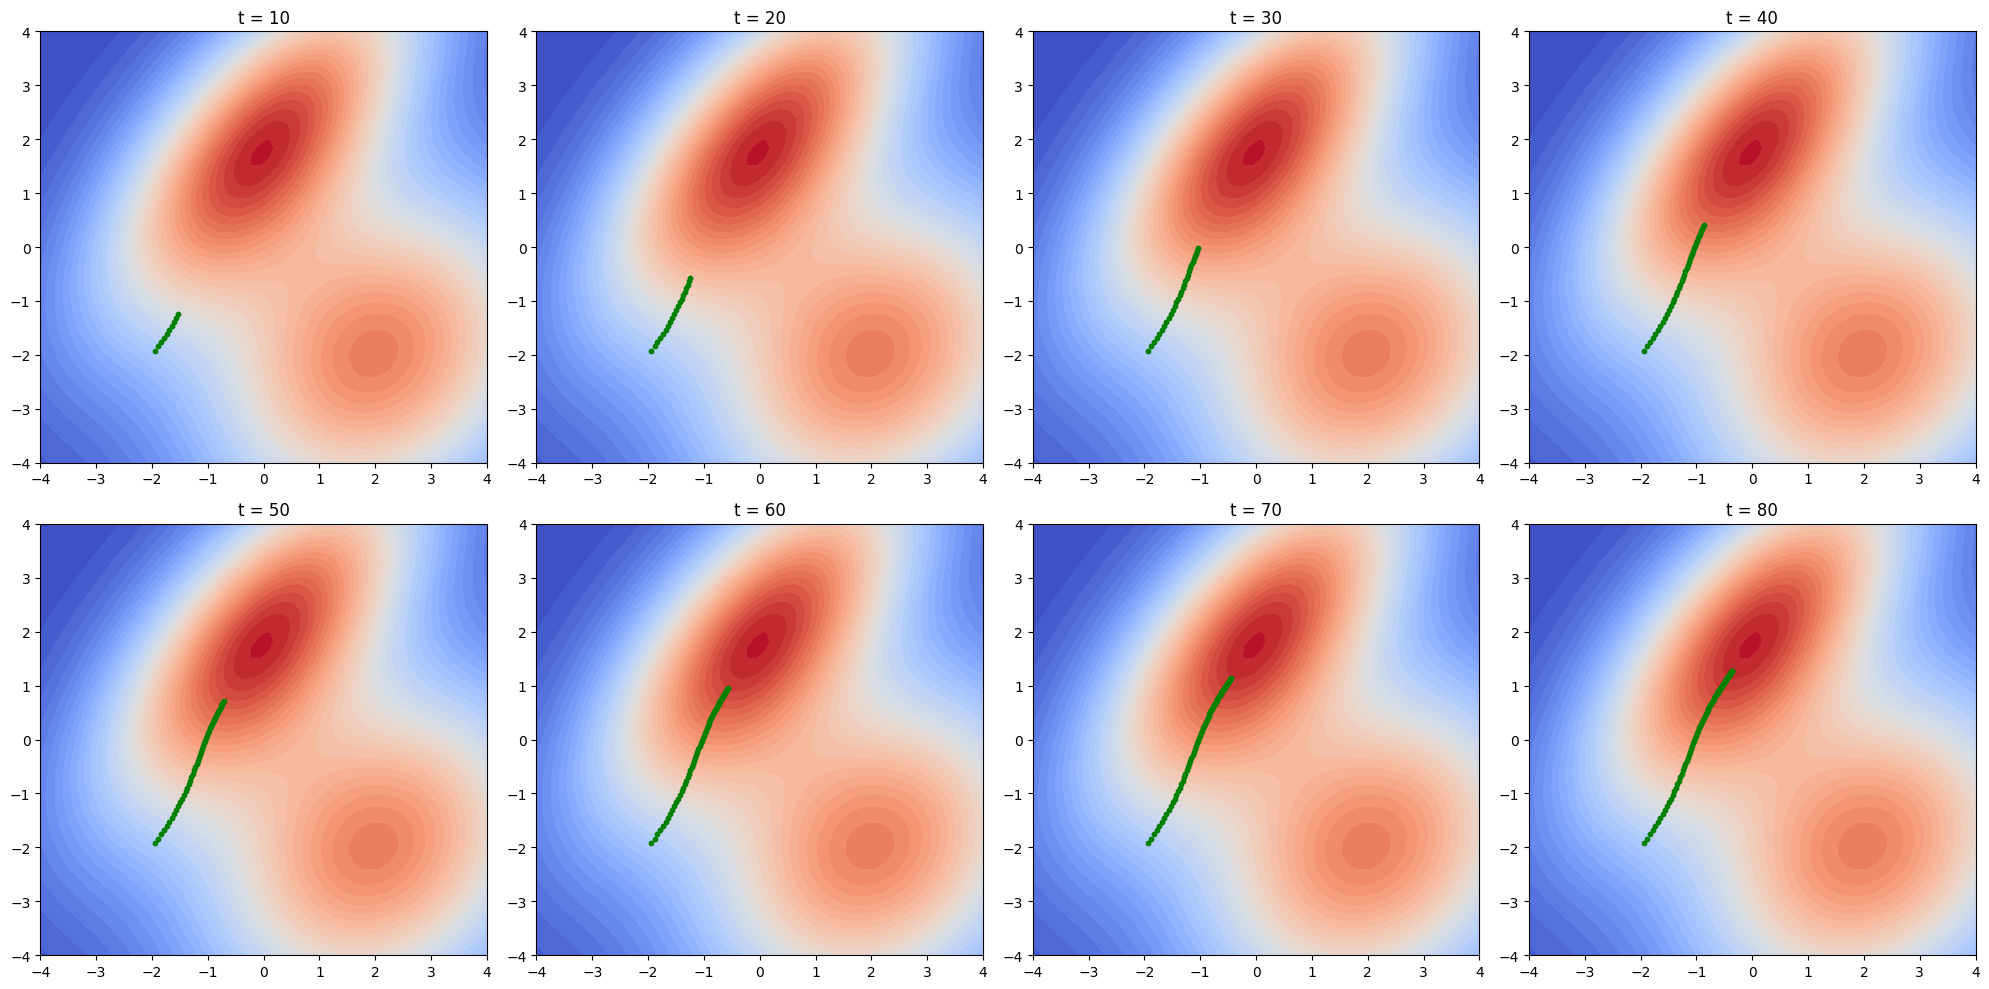

In [51]:
ts = [10, 20, 30, 40, 50, 60, 70, 80]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for t, ax in zip(ts, axes):
    
    ax.contourf(xx, yy, p_X.reshape(*xx.shape), levels=40, cmap='coolwarm')
    
    for x_t in path[:t]:
        ax.scatter(x_t[0], x_t[1], c='green', s=10)
        
    ax.set_title(f"t = {t}")

plt.tight_layout()
plt.show()

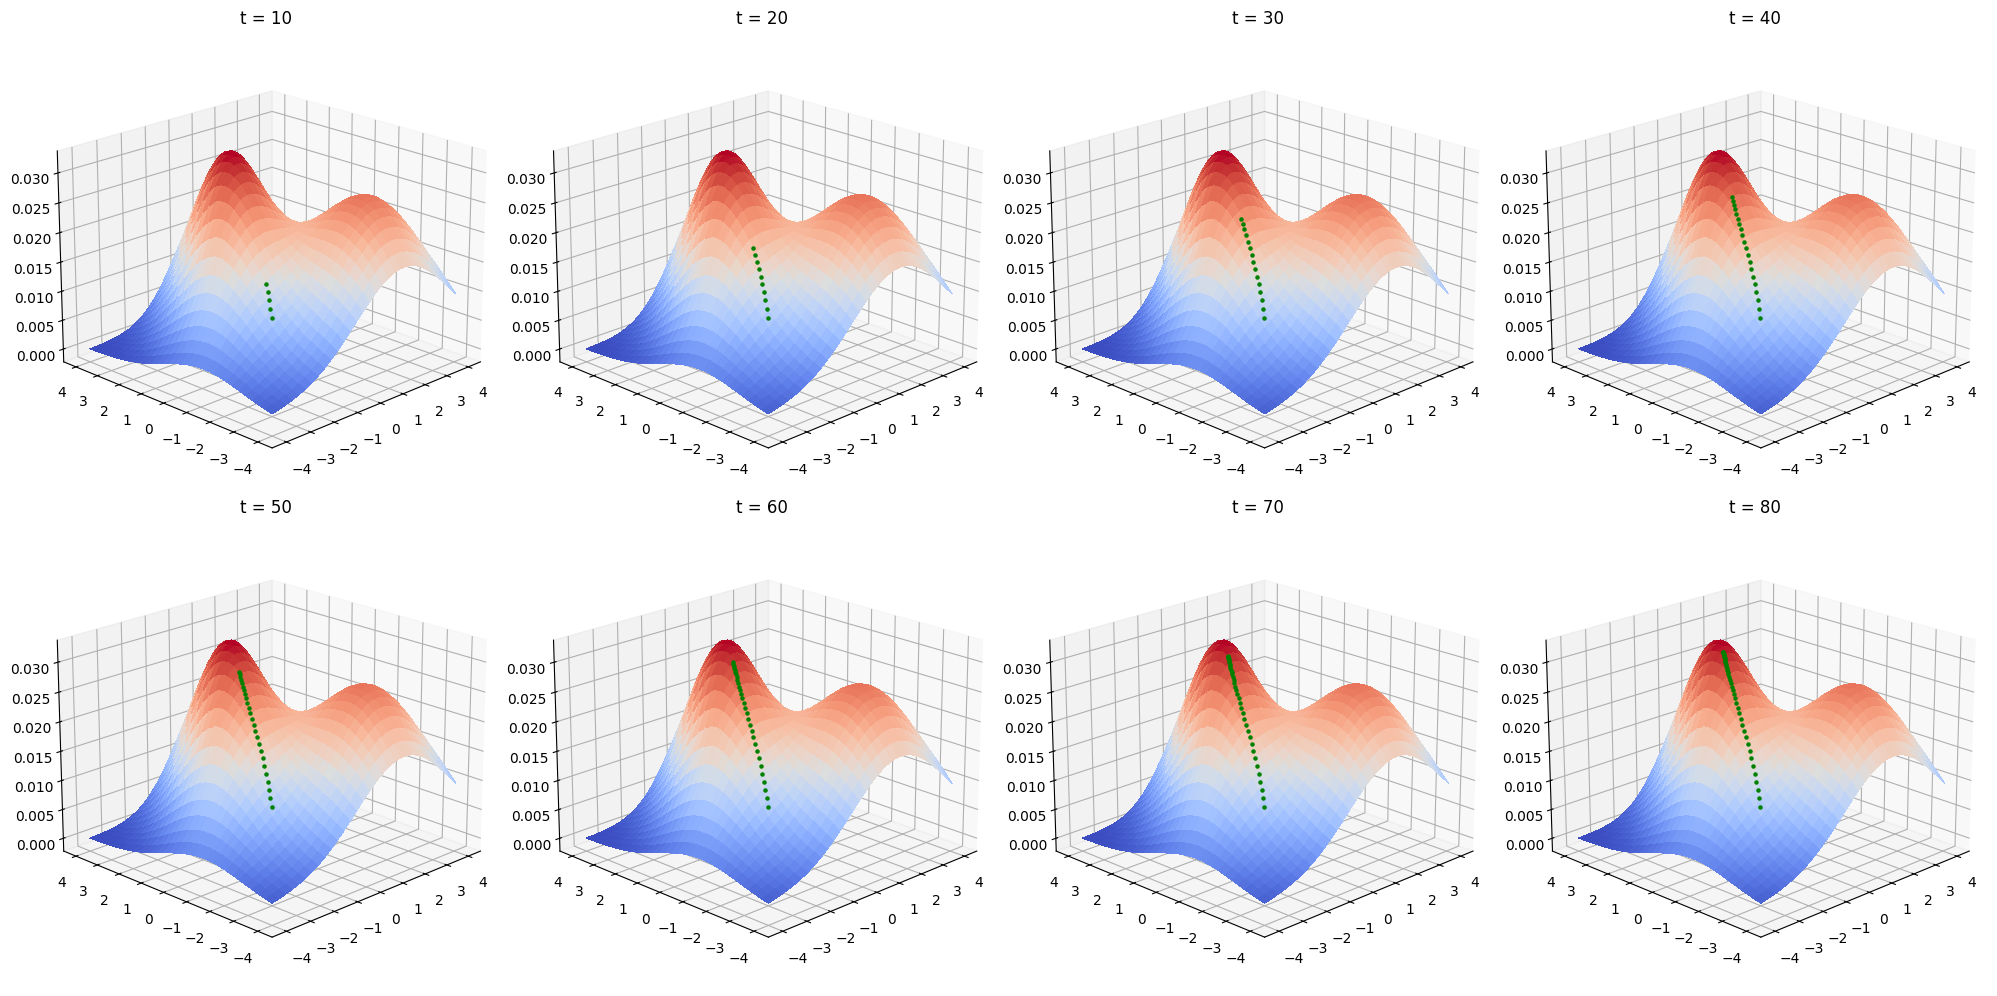

In [55]:
ts = [10, 20, 30, 40, 50, 60, 70, 80]

fig = plt.figure(figsize=(20, 10))

for i, t in enumerate(ts):
    
    ax = fig.add_subplot(2, 4, i+1, projection='3d', computed_zorder=False)
    
    ax.plot_surface(xx, yy, p_X.reshape(*xx.shape), cmap='coolwarm', linewidth=0, antialiased=False)
    ax.view_init(20, -135)
    
    for x_t in path[:t:2]:
        ax.scatter(x_t[0], x_t[1], p_data(x_t), c='green', s=5)
        
    ax.set_title(f"t = {t}")

plt.tight_layout()
plt.show()

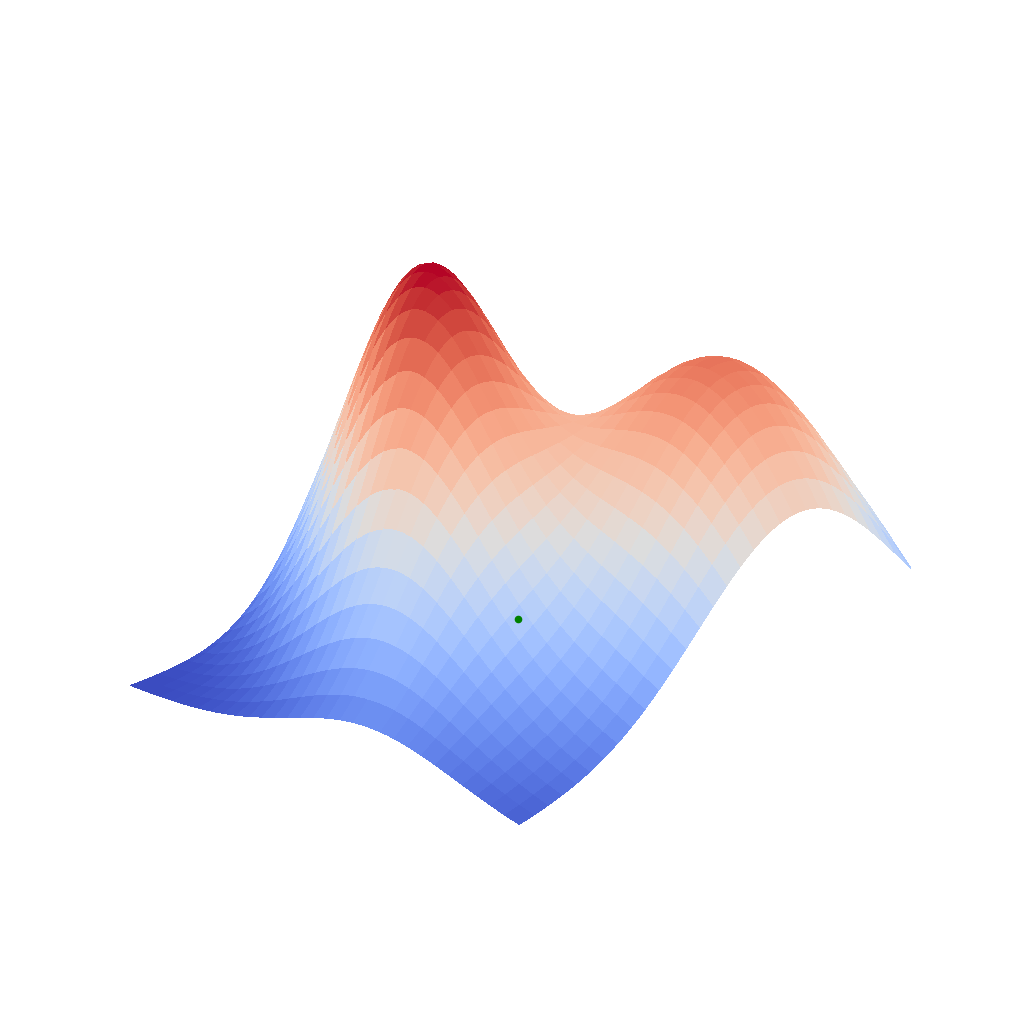

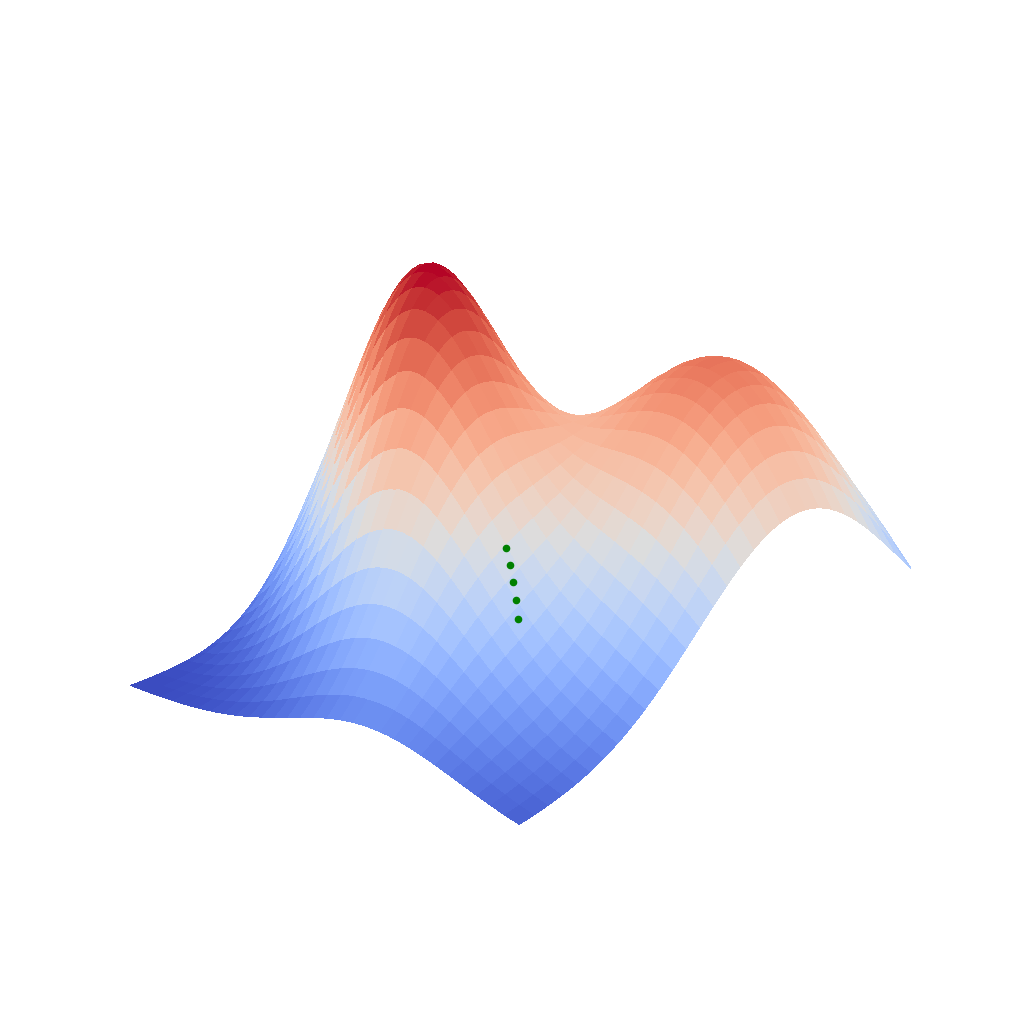

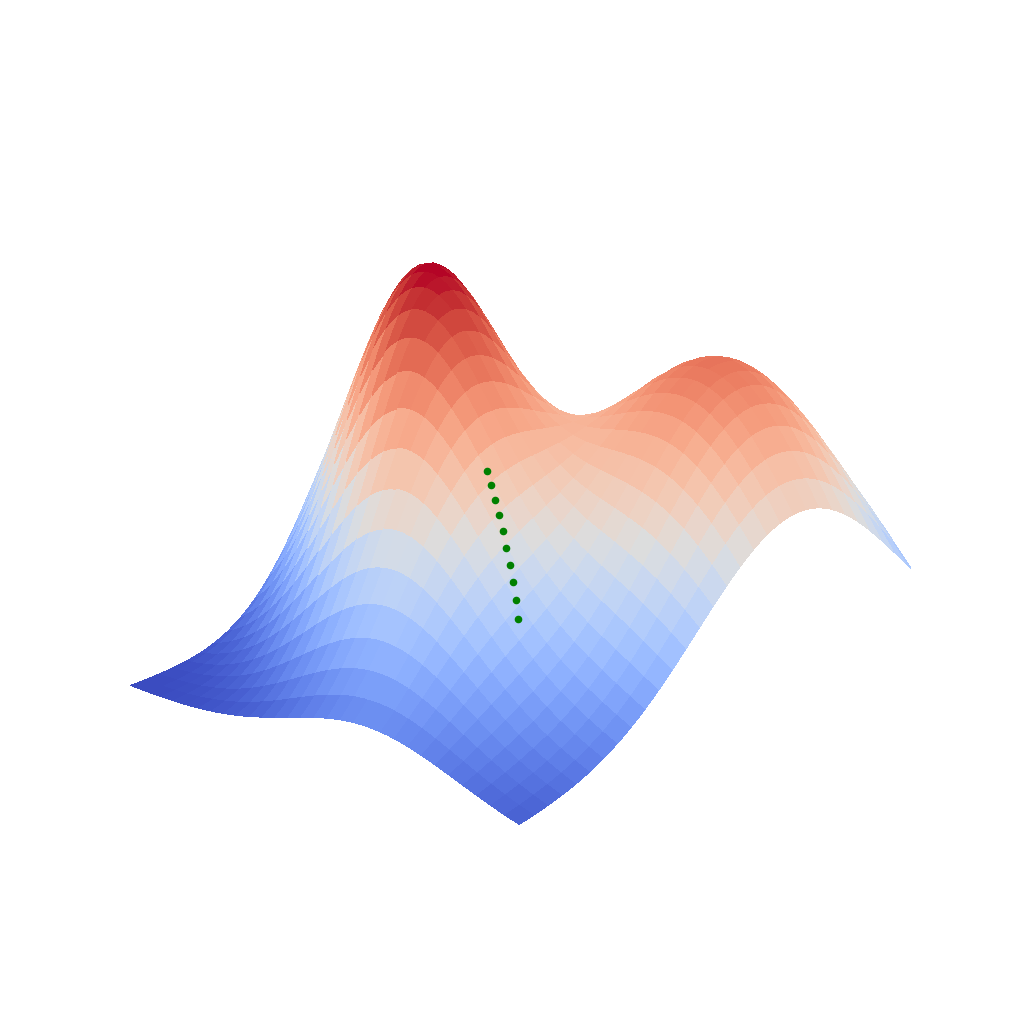

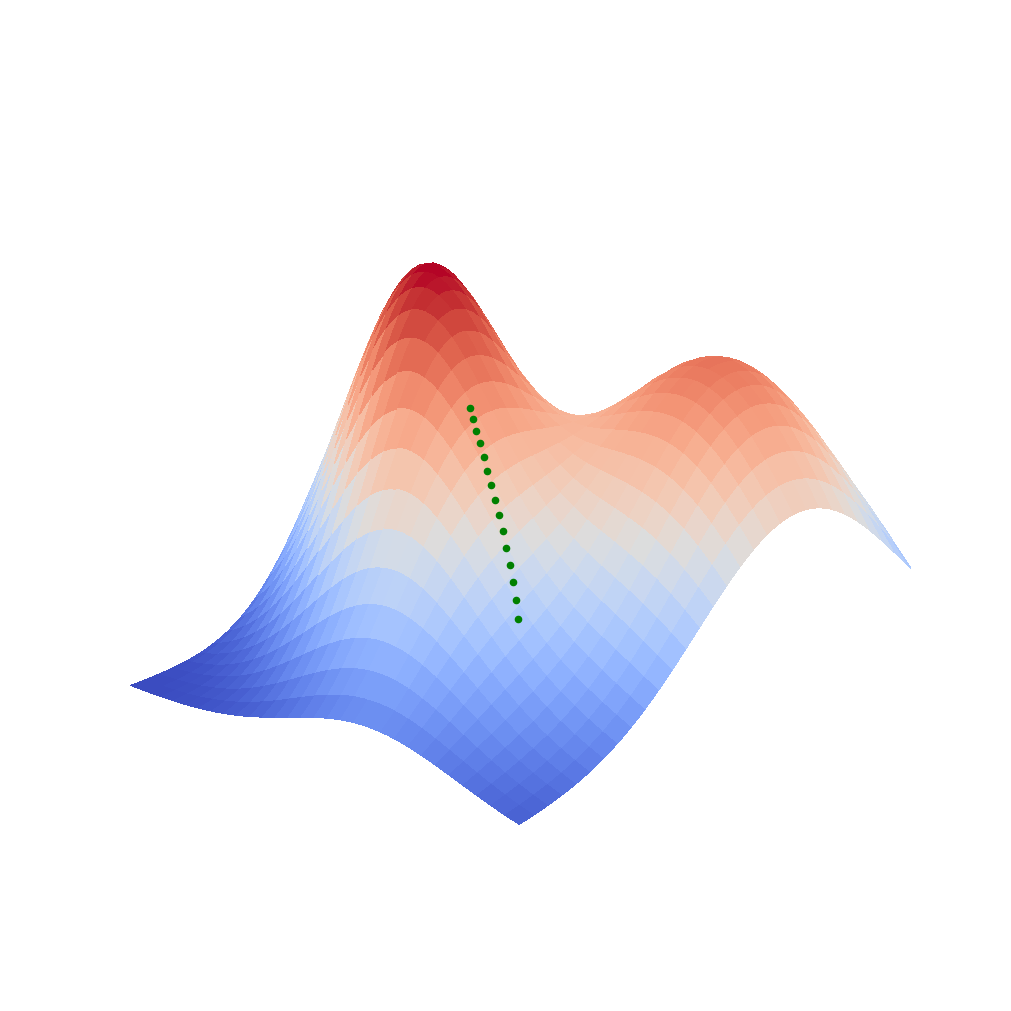

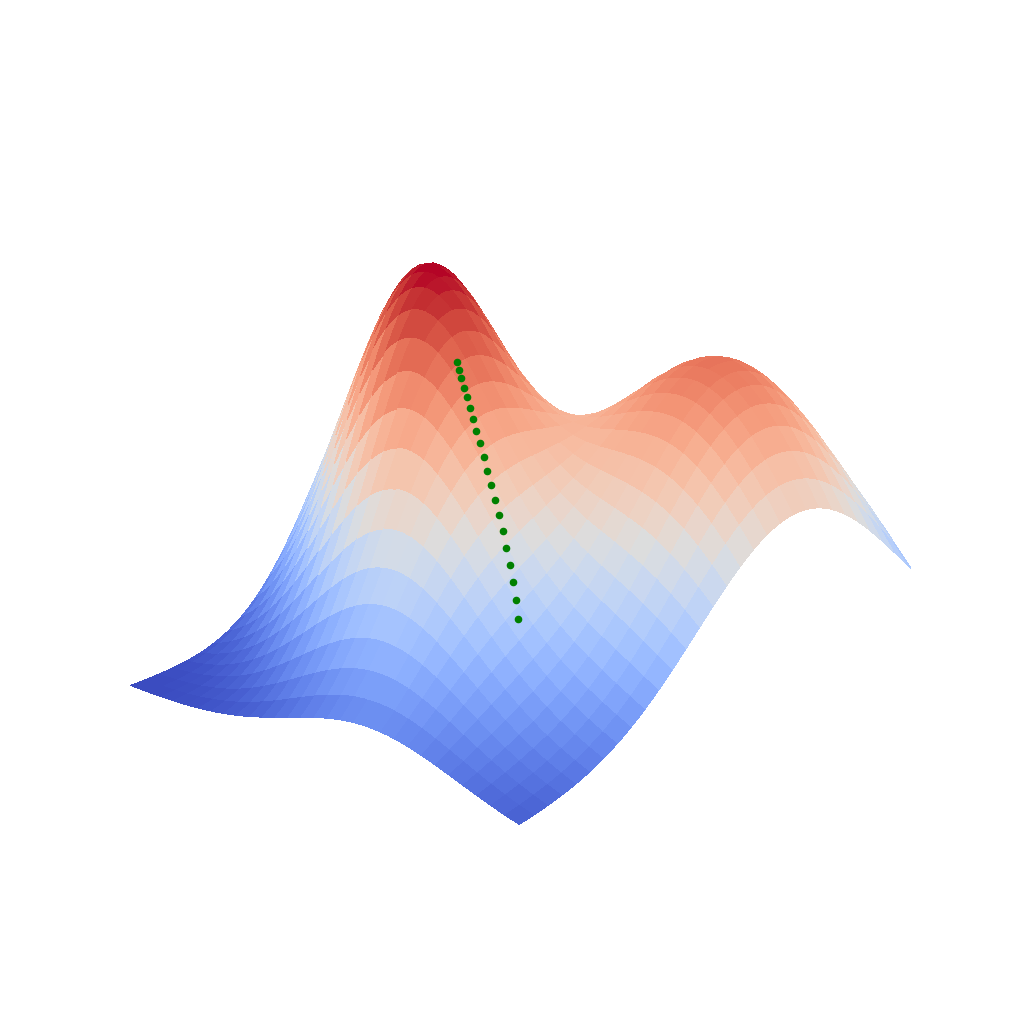

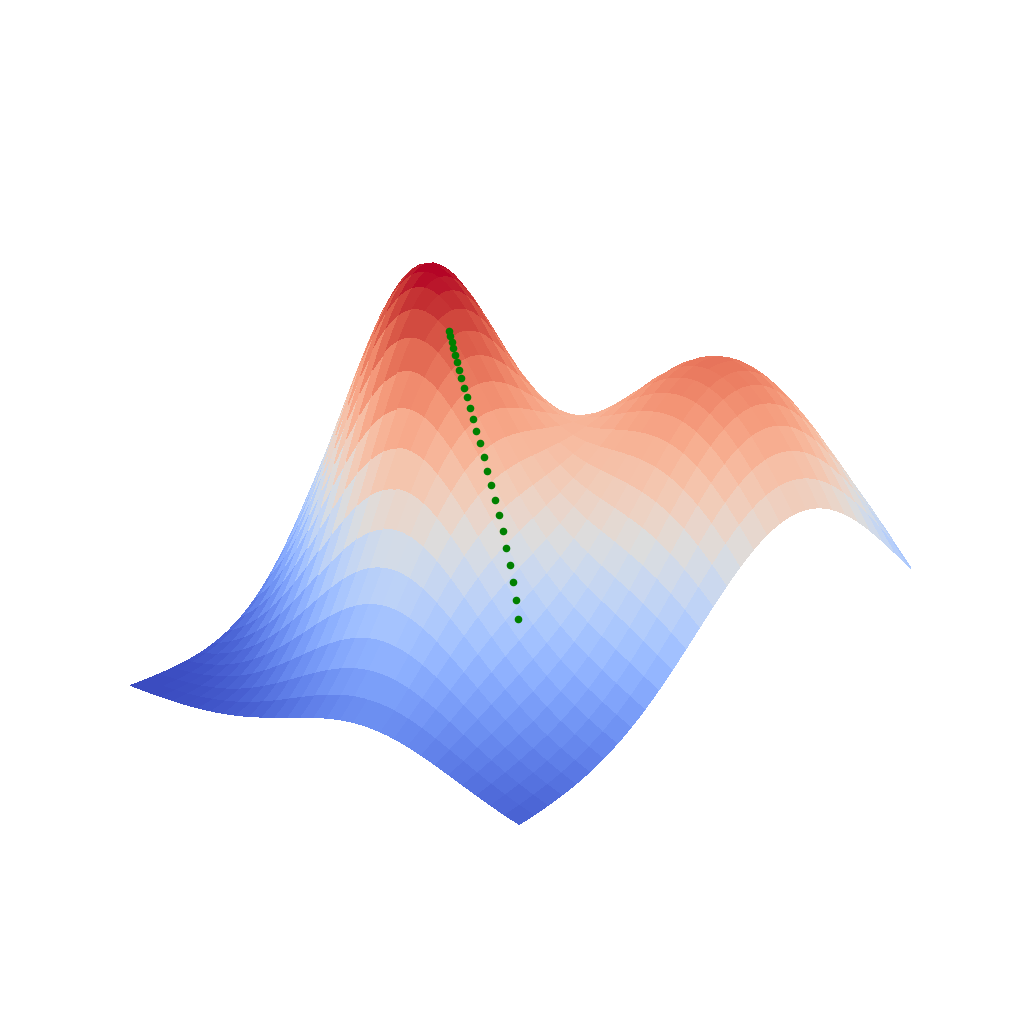

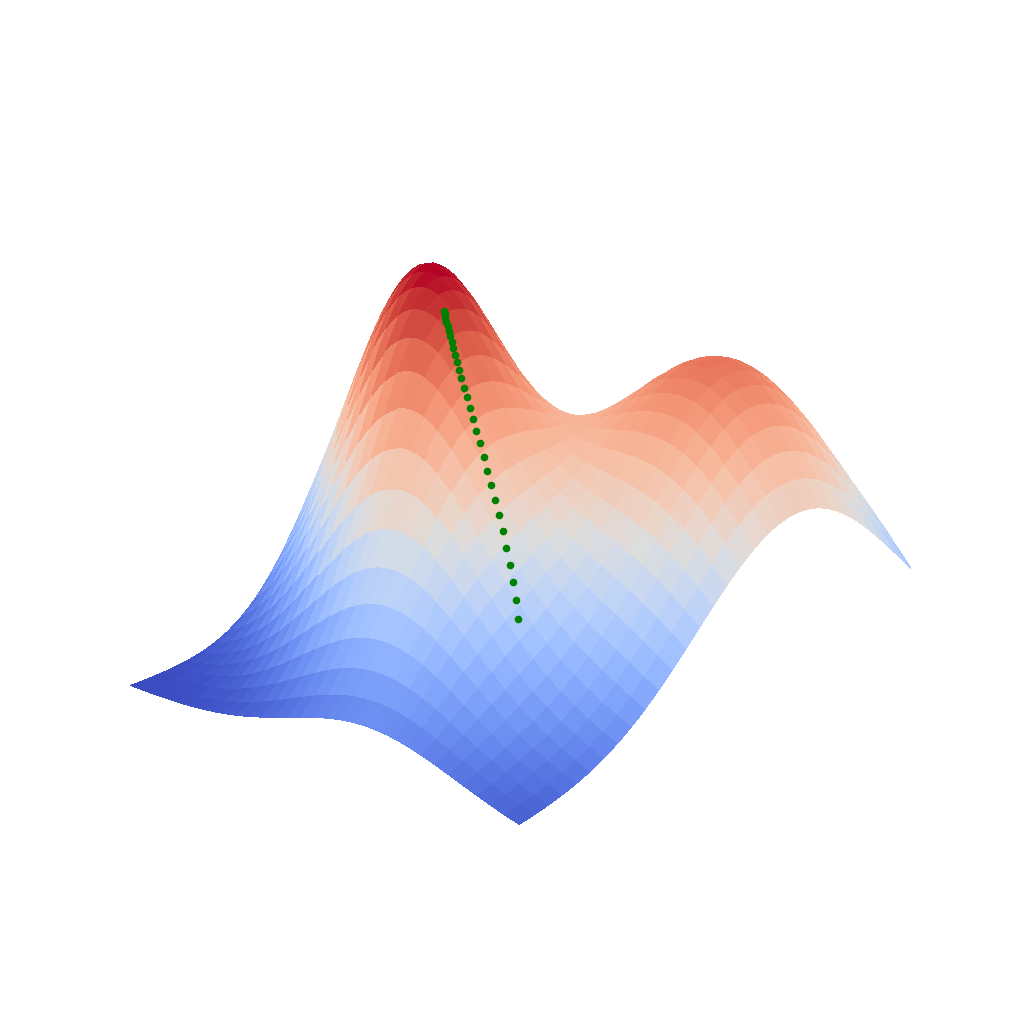

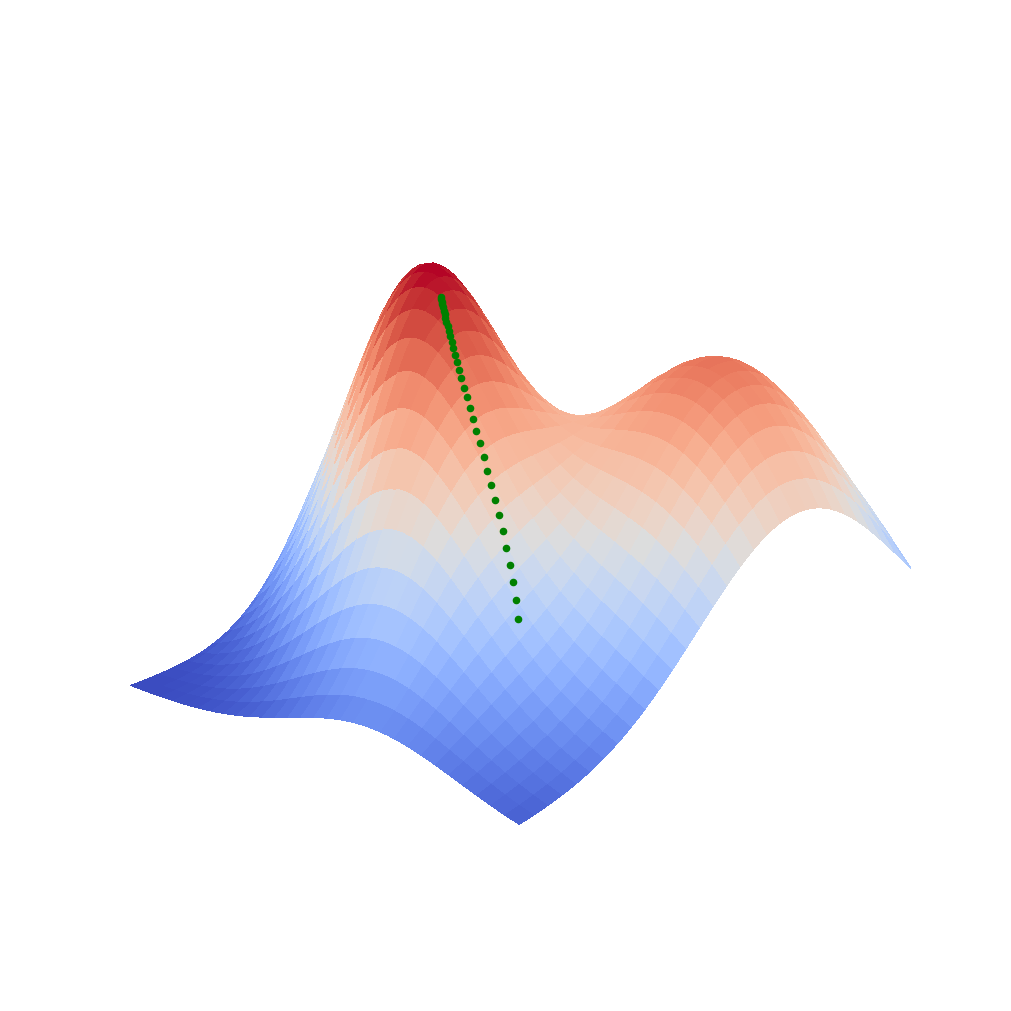

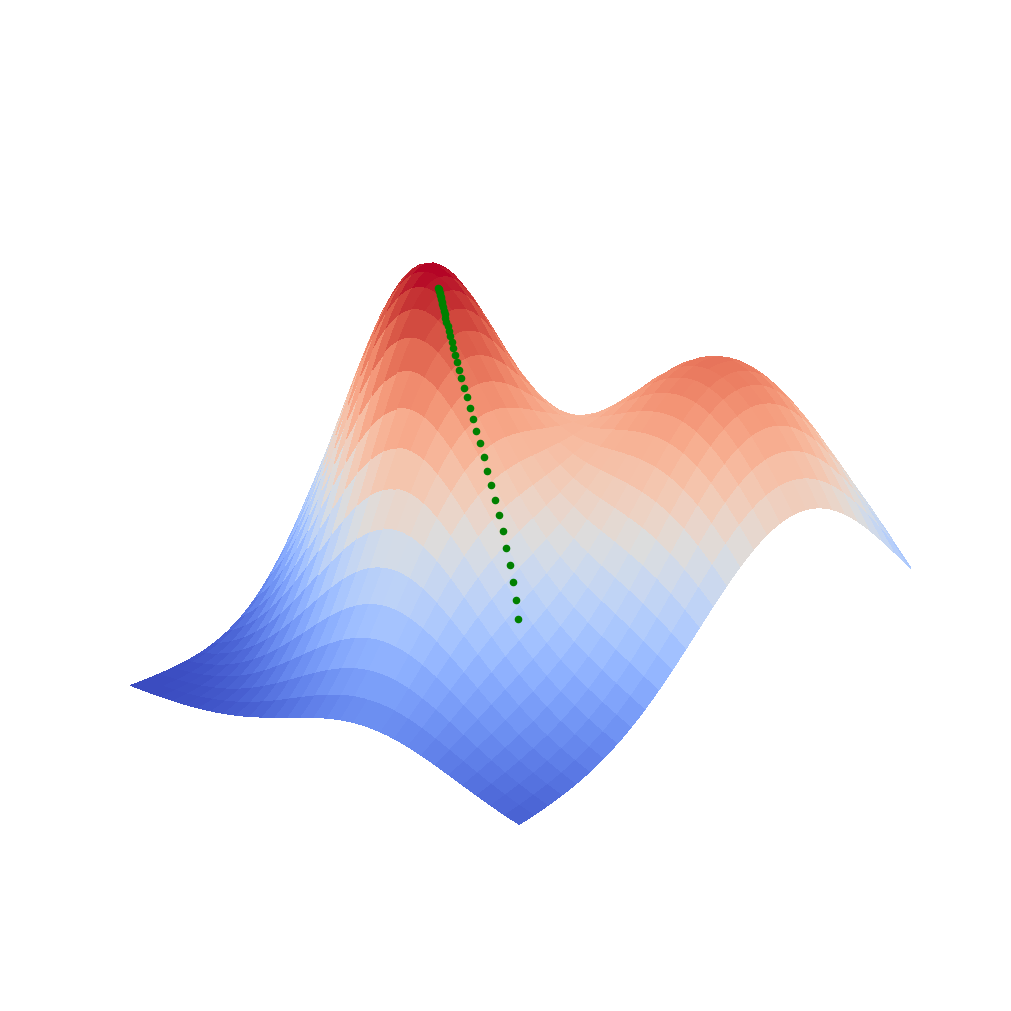

In [97]:
ts = [1, 10, 20, 30, 40, 50, 60, 70, 80]

for i, t in enumerate(ts[:]):
    
    fig = plt.figure(figsize=(10, 10), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1, projection='3d', computed_zorder=False)
    
    ax.plot_surface(xx, yy, p_X.reshape(*xx.shape), cmap='coolwarm', linewidth=0, antialiased=False)
    ax.view_init(20, -135)
    
    for x_t in path[:t:2]:
        ax.scatter(x_t[0], x_t[1], p_data(x_t), c='green', s=20)
        
    # ax.set_title(f"$t = {t}$", y=0.55, loc='right')
    ax.axis('off')
    
    plt.savefig(f"../outputs/gradient_ascent/t-{i}.png", dpi=200, bbox_inches='tight')
    plt.show()

## Langevin dynamics

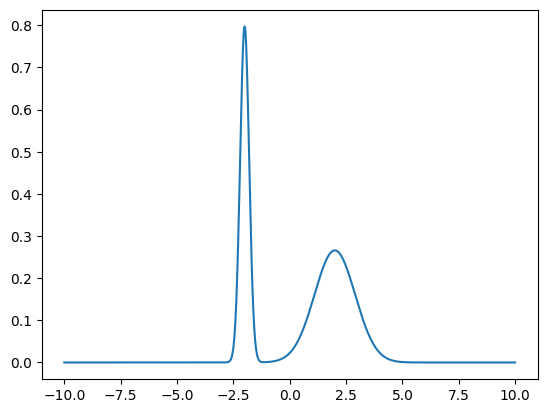

In [19]:
# general formula for a univariate Gaussian
def gaussian(x, mu, sigma):
    return 1/(sigma * (2*torch.pi)**0.5) * torch.exp(-.5 * (x-mu)**2 / sigma**2)

# sample points
x = torch.linspace(-10, 10, 1000)

# Gaussian mixture parameters
mu_1, mu_2 = 2, -2
sigma_1, sigma_2 = 0.9, 0.2
pi = 0.6
p = lambda x: pi*gaussian(x, mu_1, sigma_1) + (1-pi)*gaussian(x, mu_2, sigma_2)

# compute distribution
p_x = p(x)
plt.plot(x, p_x)

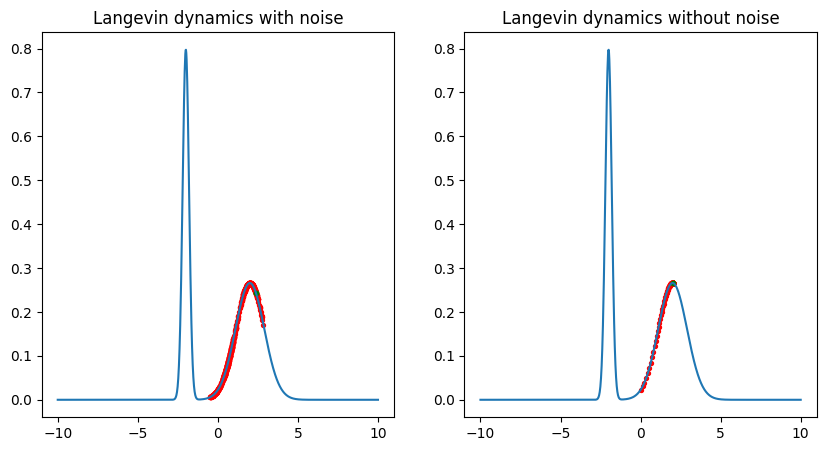

In [3]:
# langevin dynamics steps
n_steps = 800

# x_t without noise (gradient ascent)
x_ts_no_noise = []
# x_t with noise (stochastic gradient ascent)
x_ts = []

# step size
tau_no_noise = 0.05
tau = 0.008

# initial point
x_t_no_noise = torch.tensor(0., requires_grad=True)
x_t = torch.tensor(0., requires_grad=True)

for step in range(n_steps):
    
    # deterministic gradient ascent
    x_ts_no_noise.append(x_t_no_noise.item())
    if x_t_no_noise.grad is not None: x_t_no_noise.grad.zero_()
    
    p(x_t_no_noise).log().backward()
    x_t_no_noise = (x_t_no_noise + tau_no_noise * x_t_no_noise.grad).clone().detach().requires_grad_(True)
    
    # stochastic gradient ascent
    x_ts.append(x_t.item())
    if x_t.grad is not None: x_t.grad.zero_()
    
    p(x_t).log().backward()
    x_t = (x_t + .5*tau * x_t.grad + tau**.5 * torch.randn(1)).clone().detach().requires_grad_(True)
    

x_ts = torch.tensor(x_ts)
x_ts_no_noise = torch.tensor(x_ts_no_noise)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title("Langevin dynamics with noise")
ax1.plot(x, p_x)
ax1.scatter(x_ts, p(x_ts), s=8, c='r')
ax1.scatter(x_t.detach(), p(x_t.detach()), s=10, c='g')

ax2.set_title("Langevin dynamics without noise")
ax2.plot(x, p_x)
ax2.scatter(x_ts_no_noise, p(x_ts_no_noise), s=8, c='r')
ax2.scatter(x_t_no_noise.detach(), p(x_t_no_noise.detach()), s=10, c='g')

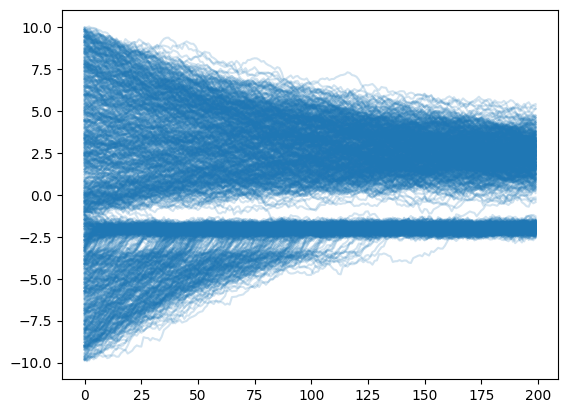

In [8]:
n_steps = 200

x_ts = []

tau = 0.007
n_samples = 1000
x_t = (torch.rand(n_samples) * 20 - 10).requires_grad_(True)

for step in range(n_steps):
    x_ts.append(x_t.detach())
    if x_t.grad is not None: x_t.grad.zero_()
    
    p(x_t).log().backward(torch.ones_like(x_t))
    x_t = (x_t + tau * x_t.grad + (2*tau)**.5 * torch.randn_like(x_t)).clone().detach().requires_grad_(True)
    # tau = tau * 0.99


x_ts = torch.stack(x_ts)

plt.plot(x_ts, c='C0', alpha=0.2)
plt.show()

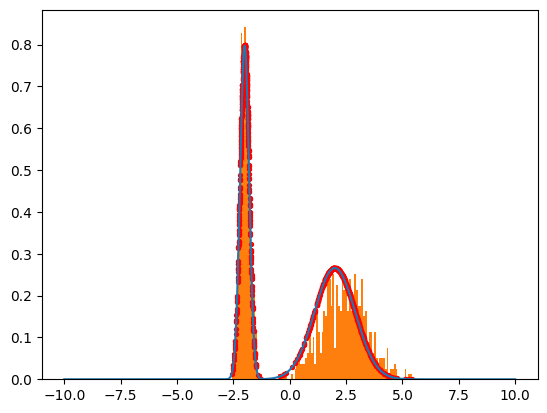

In [10]:
plt.plot(x, p_x)
plt.hist(x_ts[-1], density=True, bins=20)
plt.scatter(x_ts[-1], p(x_ts[-1]), s=8, c='r')
plt.show()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7031786f7bf0>>
Traceback (most recent call last):
  File "/home/jan/programming/python-dev/generative_modeling/venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 

KeyboardInterrupt



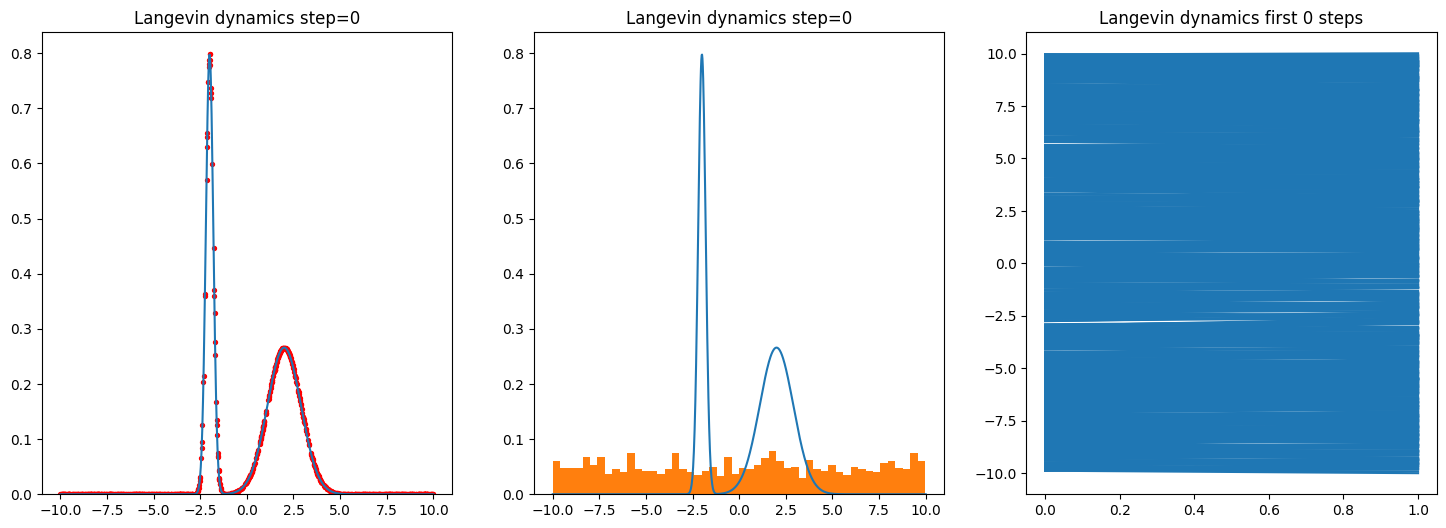

In [21]:
from matplotlib import animation

fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2, sharey = ax1)
ax3 = fig.add_subplot(1, 3, 3)

def animate(i):
    
    ax1.clear()
    ax1.plot(x, p_x, label='Unknown distribution')
    ax1.scatter(x_ts[i], p(x_ts[i]), s=8, c='r', label='Estimated distribution')
    ax1.set_title(f'Langevin dynamics step={i}')
    
    ax2.clear()
    ax2.plot(x, p_x, label='Unknown distribution')
    ax2.hist(x_ts[i], density=True, bins=50, label='Estimated distribution')
    ax2.set_title(f'Langevin dynamics step={i}')
    
    ax3.plot(x_ts[:i], color='C0')
    ax3.set_title(f'Langevin dynamics first {i} steps')
    return 

anim = animation.FuncAnimation(fig, animate, frames=len(x_ts), repeat=False, interval=10)
anim.save('../outputs/langevin_dynamics.mp4', writer=animation.FFMpegWriter(fps=60))

### Fisher Divergence

Distance metric between gradient w.r.t $x$ of two distributions $p(x)$ and $q(x)$
$$
    \mathbb{E}_{x \sim q(x)}[||\nabla_x \log p(x) - \nabla_x \log q(x)||_2^2]
$$

Suppose $p(x)$ is the unknown data distribution, and we use a neural network $q(x)$ to estimate this unknown distribution, then using gradient descent on $x$ rather than the weights, we can update $x$ such that we get an $x$ that is approximately sampled from $p(x)$ by reducing the Fisher divergence. 

In [2]:
# general formula for a univariate Gaussian
def gaussian(x, mu, sigma):
    return 1/(sigma * (2*torch.pi)**0.5) * torch.exp(-.5 * (x-mu)**2 / sigma**2)

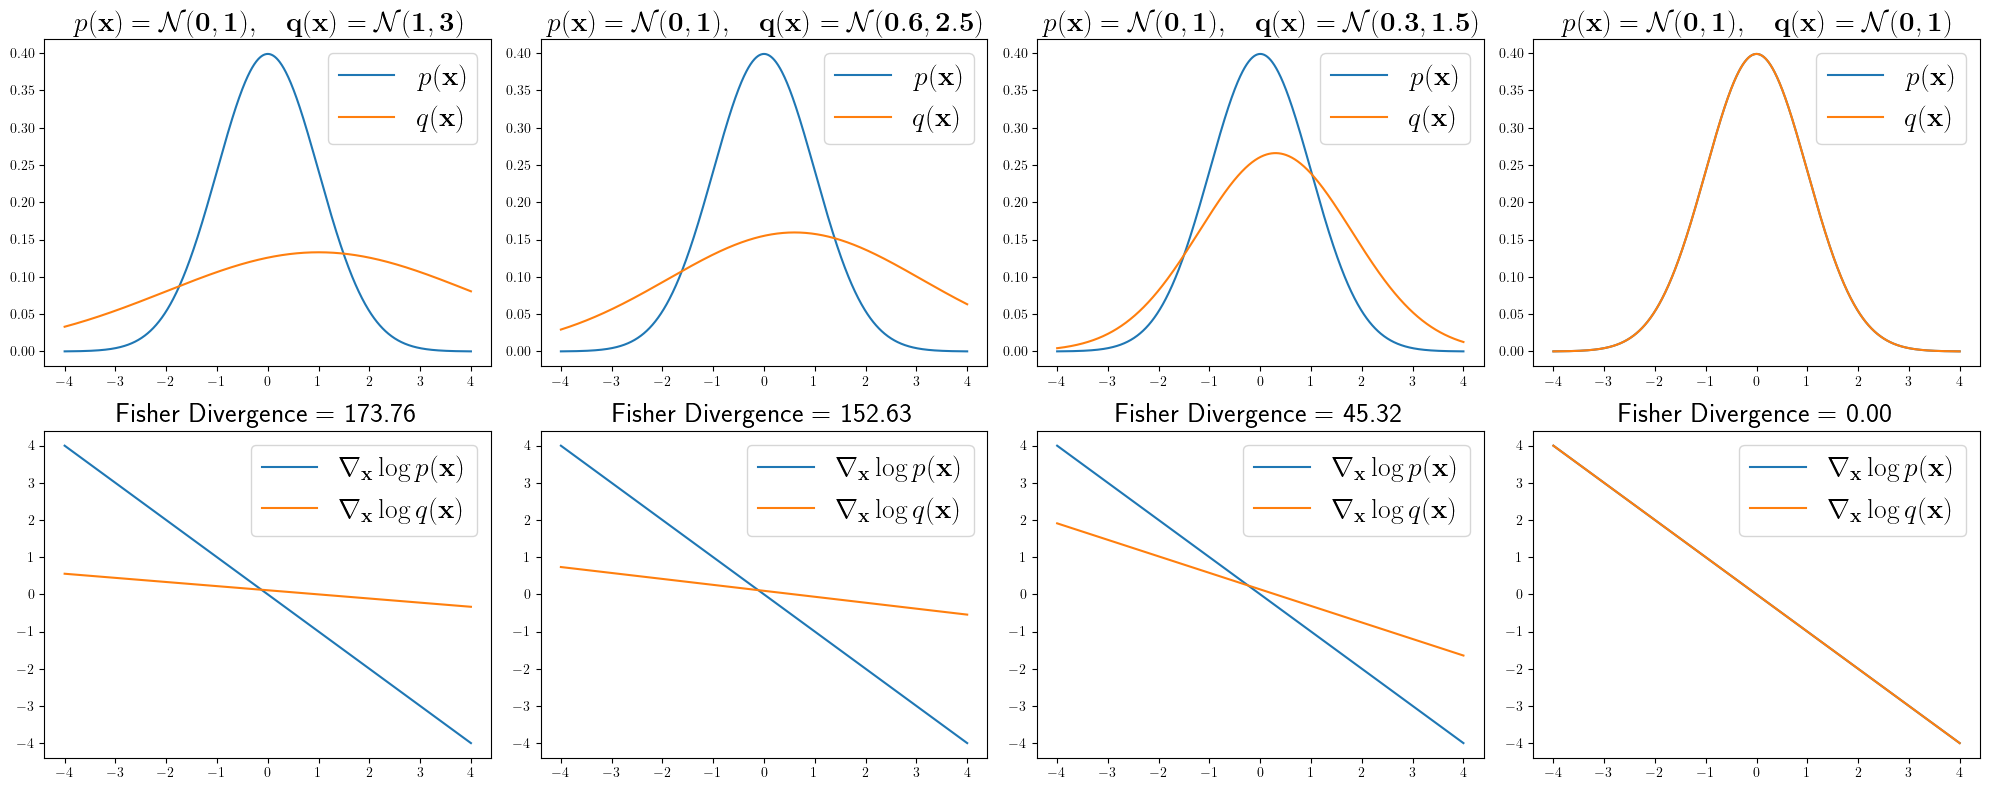

In [5]:
plt.rcParams['text.usetex'] = True

# define a linear range of values between -4 and 4
x = torch.linspace(-4, 4, 1000, requires_grad=True)

p_mu = 0
p_var = 1
q_mus = [1, 0.6, 0.3, 0]
q_vars = [3, 2.5, 1.5, 1]

_, axes = plt.subplots(2, 4, figsize=(20, 8))

font_size = 20

for q_mu, q_var, ax_row in zip(q_mus, q_vars, axes.T):
    # reset gradient to zero
    x.grad = None

    # constant p(x)
    p = gaussian(x, p_mu, p_var)
    log_p = torch.log(p)
    log_p.backward(torch.ones_like(log_p))
    ax_row[1].plot(x.detach().numpy(), x.grad.data, label=r'$\nabla_{\bf{x}} \log p(\bf{x})$')
    deriv_log_p = x.grad.data.clone()

    # reset gradient to zero
    x.grad = None

    # varying q(x)
    q = gaussian(x, q_mu, q_var)
    log_q = torch.log(q)
    log_q.backward(torch.ones_like(log_q))
    ax_row[1].plot(x.detach().numpy(), x.grad.data, label=r'$\nabla_{\bf{x}} \log q(\bf{x})$')
    deriv_log_q = x.grad.data.clone()

    # distance between gradients
    fisher_divergence = 1/2*torch.sum(q * (deriv_log_p - deriv_log_q)**2)

    ax_row[1].set_title(f'Fisher Divergence = {fisher_divergence:.2f}', fontdict = {'fontsize' : font_size})
    ax_row[1].legend(fontsize=font_size)

    ax_row[0].plot(x.detach().numpy(), p.detach().numpy(), label=r"$p(\bf{x})$")
    ax_row[0].plot(x.detach().numpy(), q.detach().numpy(), label=r"$q(\bf{x})$")
    ax_row[0].legend(fontsize=font_size)

    ax_row[0].set_title(rf"$p(\bf{{x}}) = \mathcal{{N}}(0, 1), \quad q(\bf{{x}}) = \mathcal{{N}}({q_mu}, {q_var})$", fontdict = {'fontsize' : font_size})

plt.tight_layout()
plt.savefig('../outputs/fisher_divergence.pdf', dpi=300)

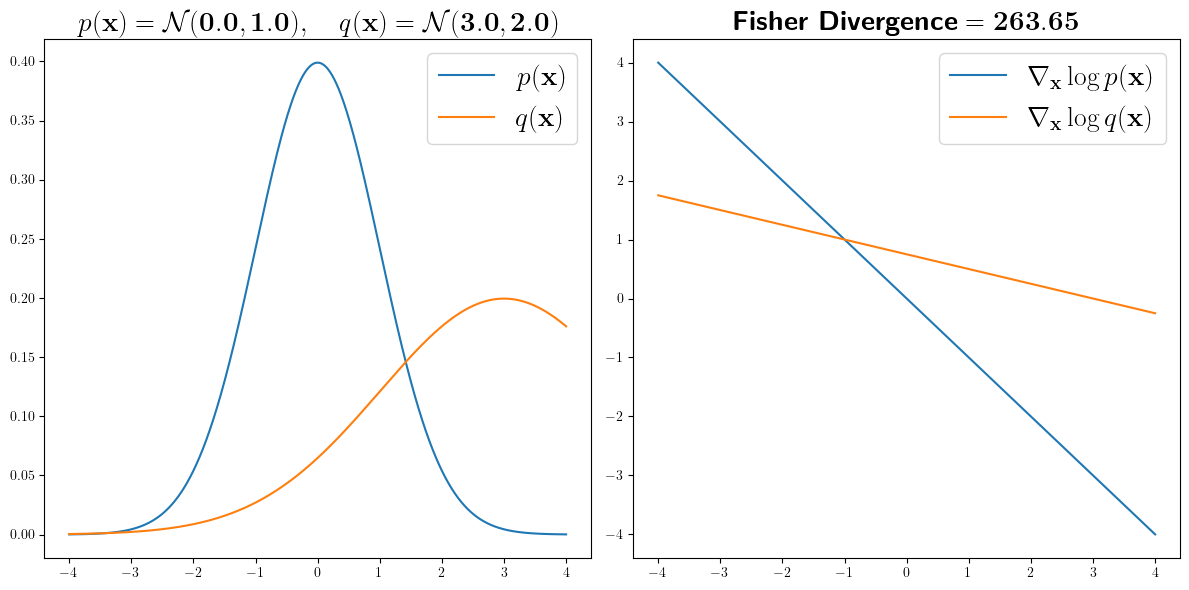

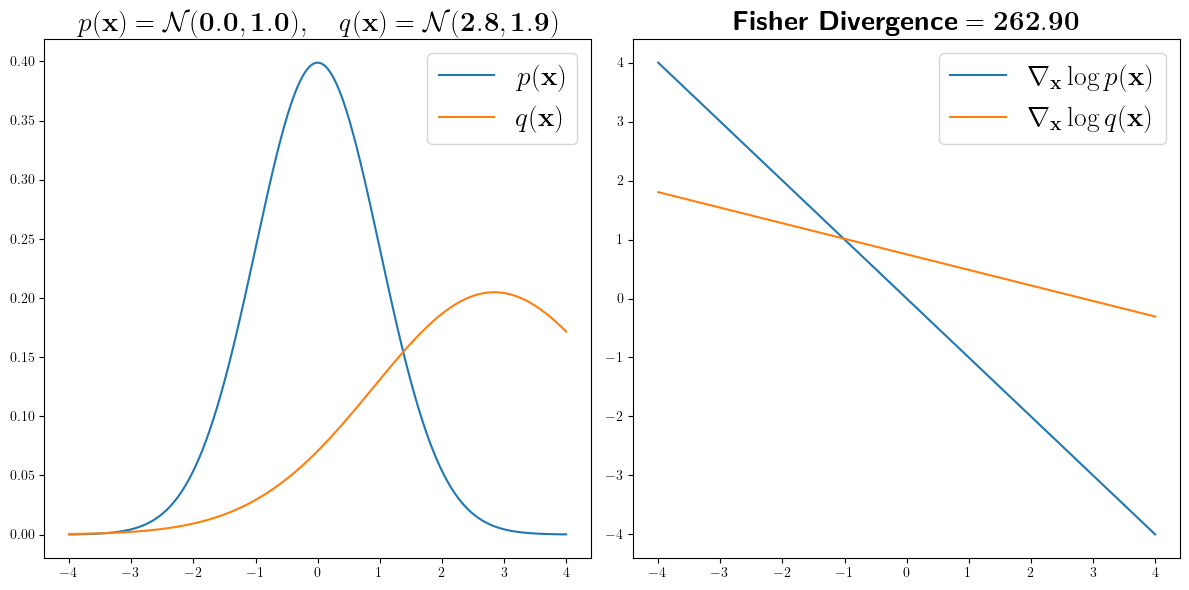

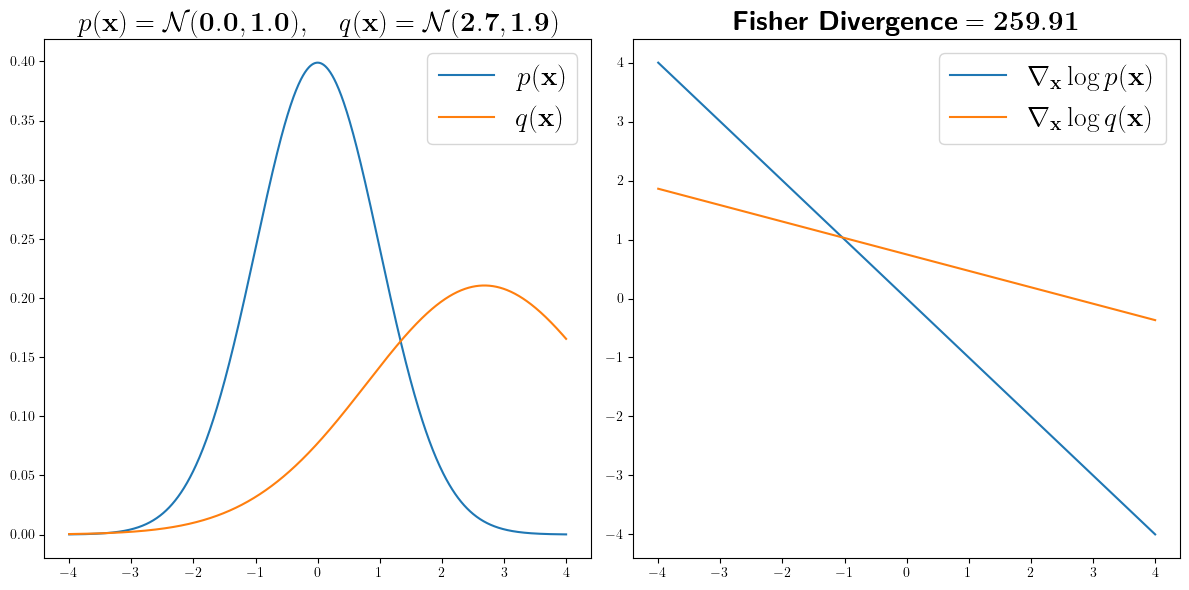

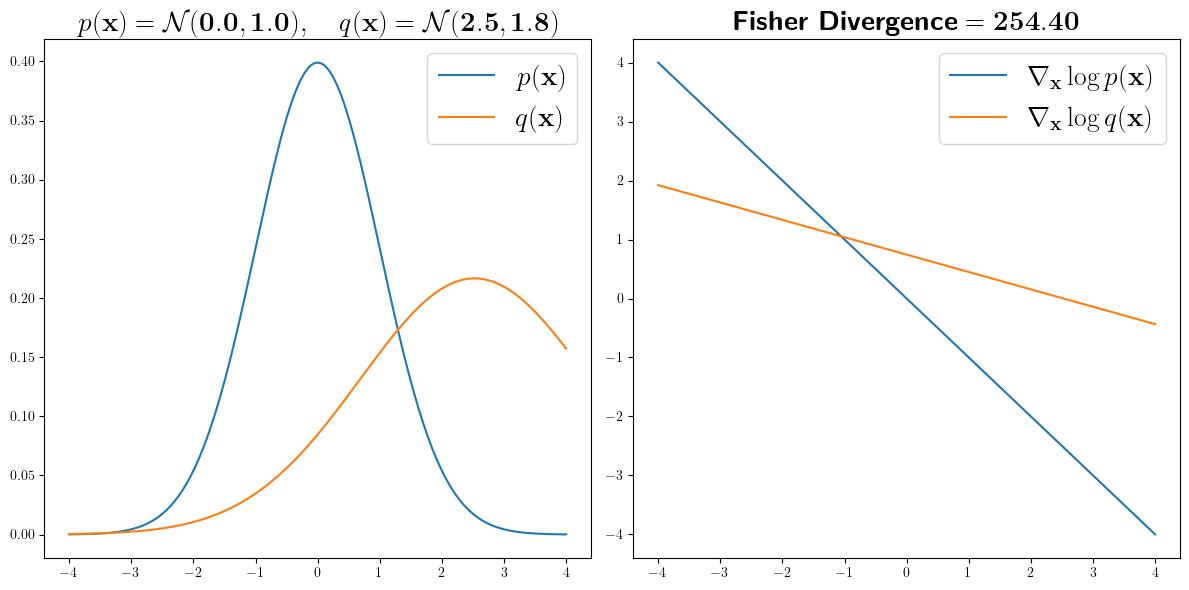

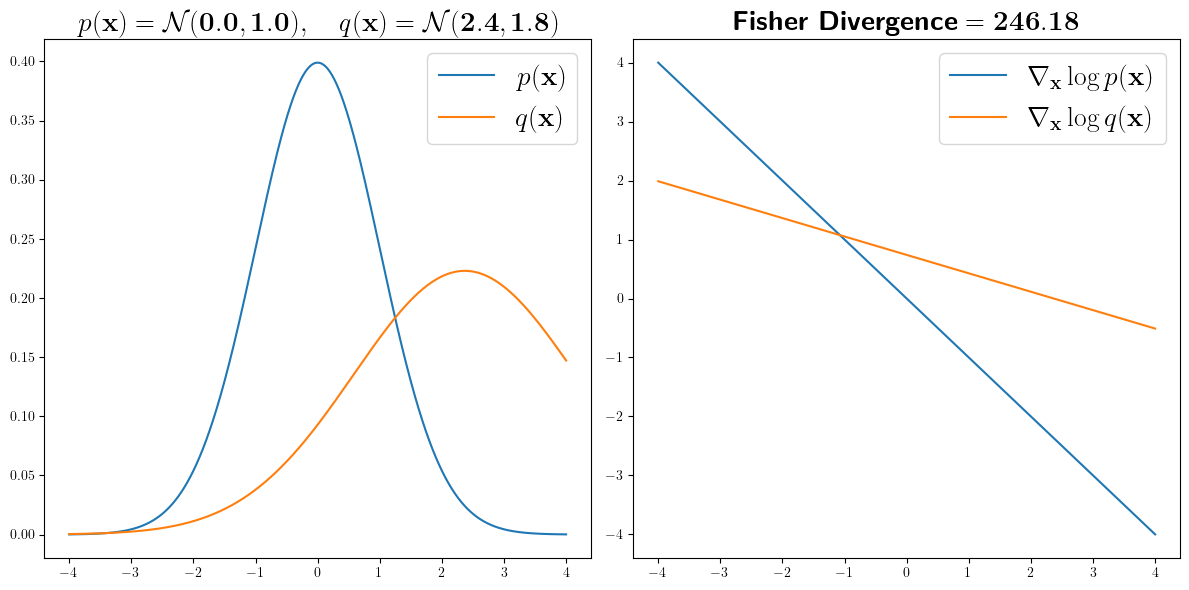

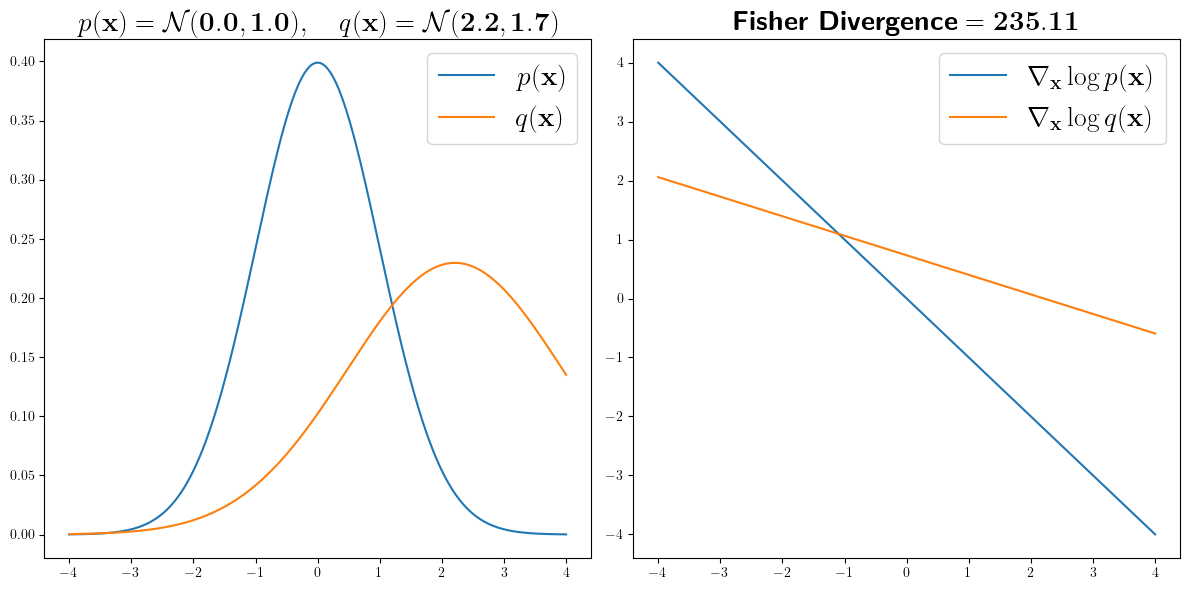

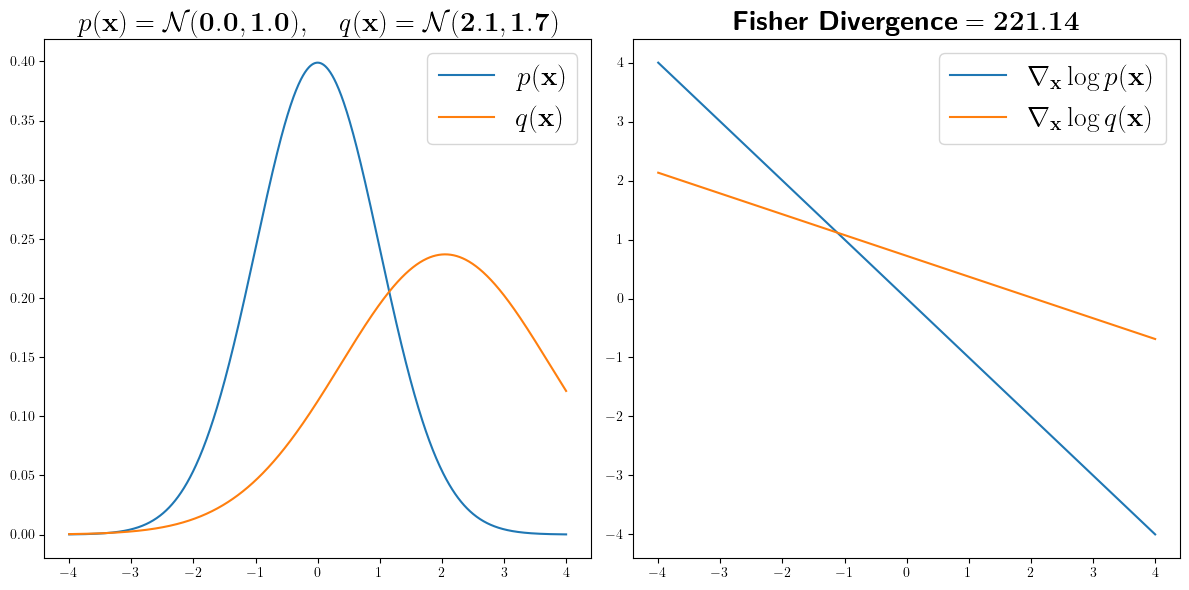

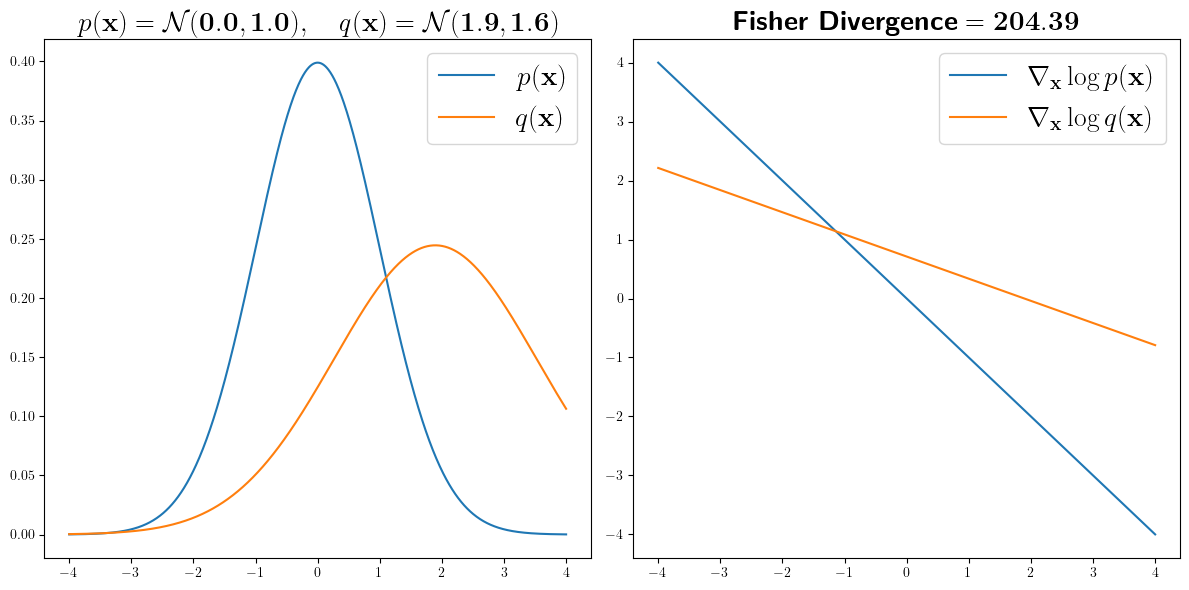

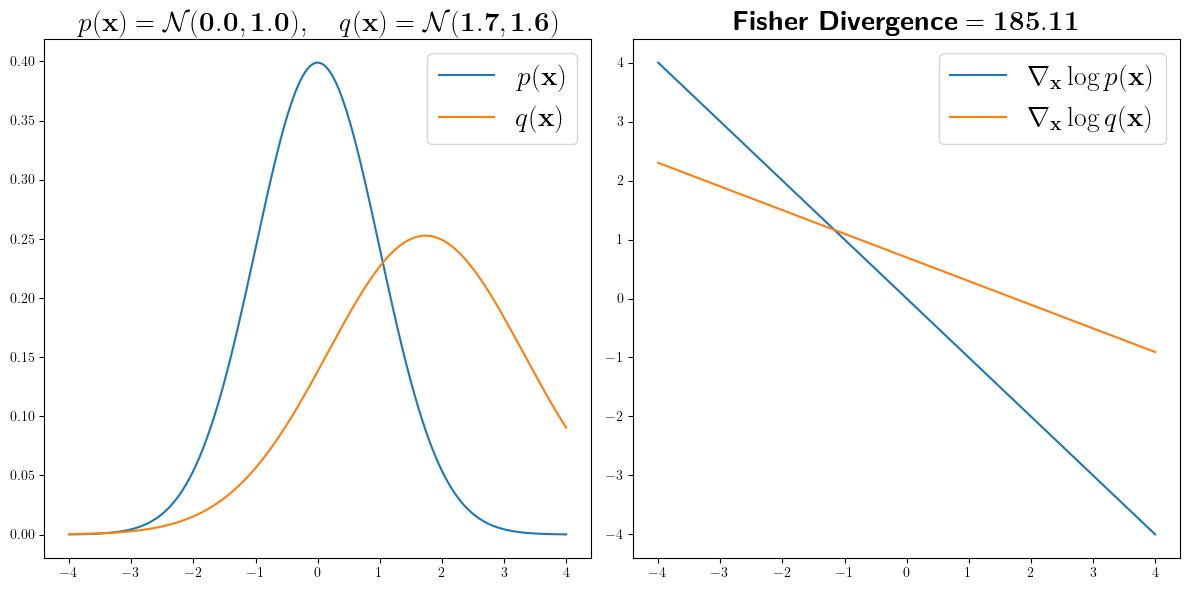

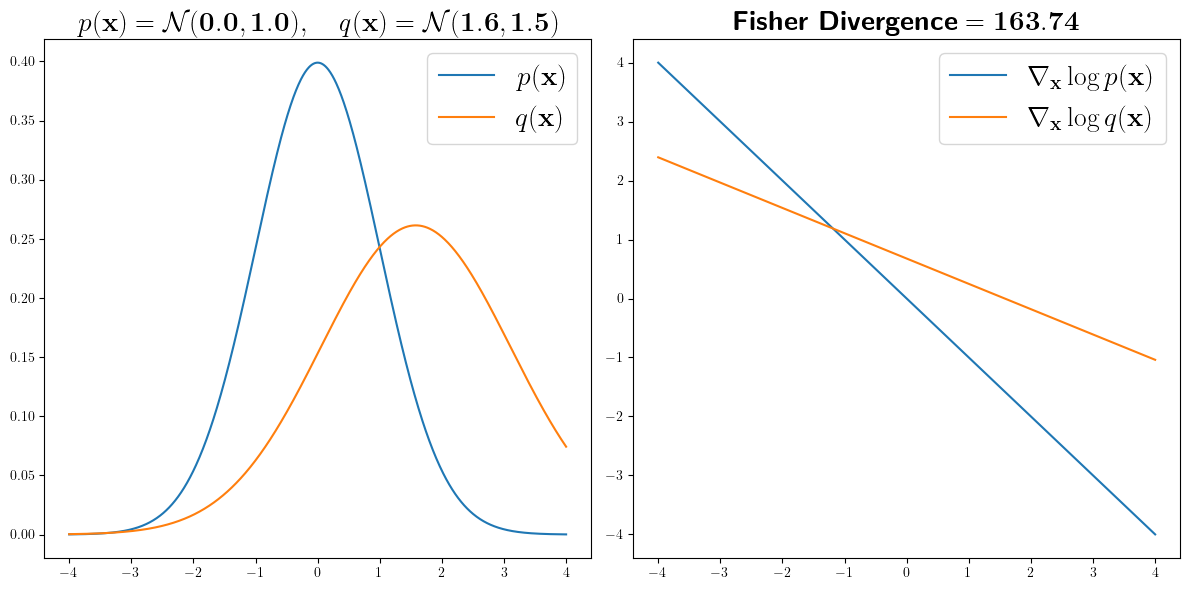

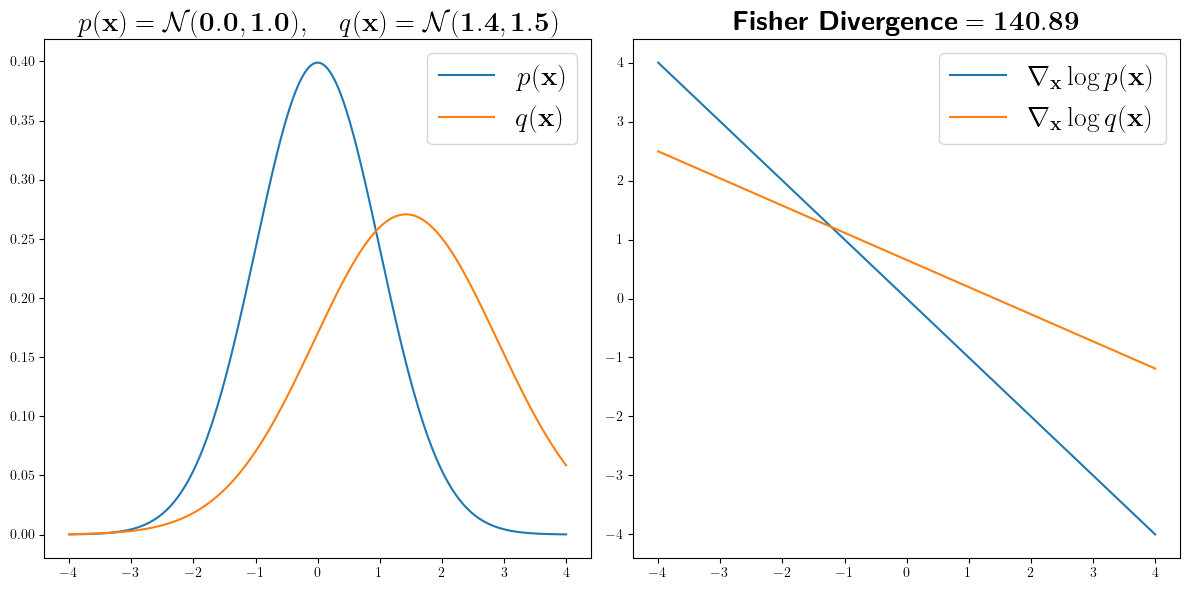

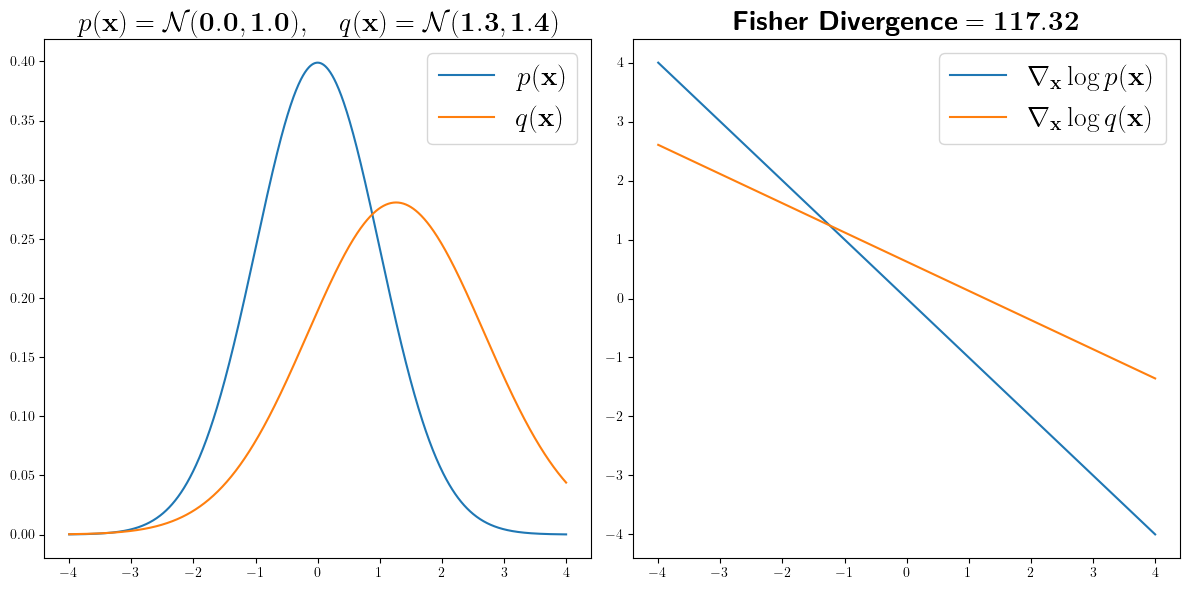

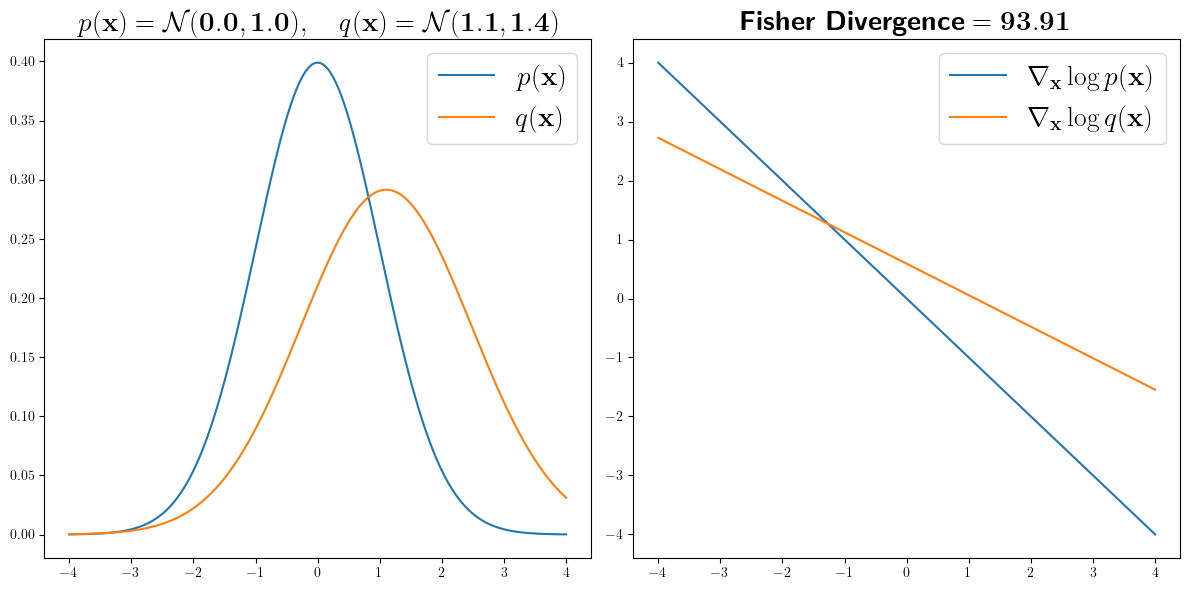

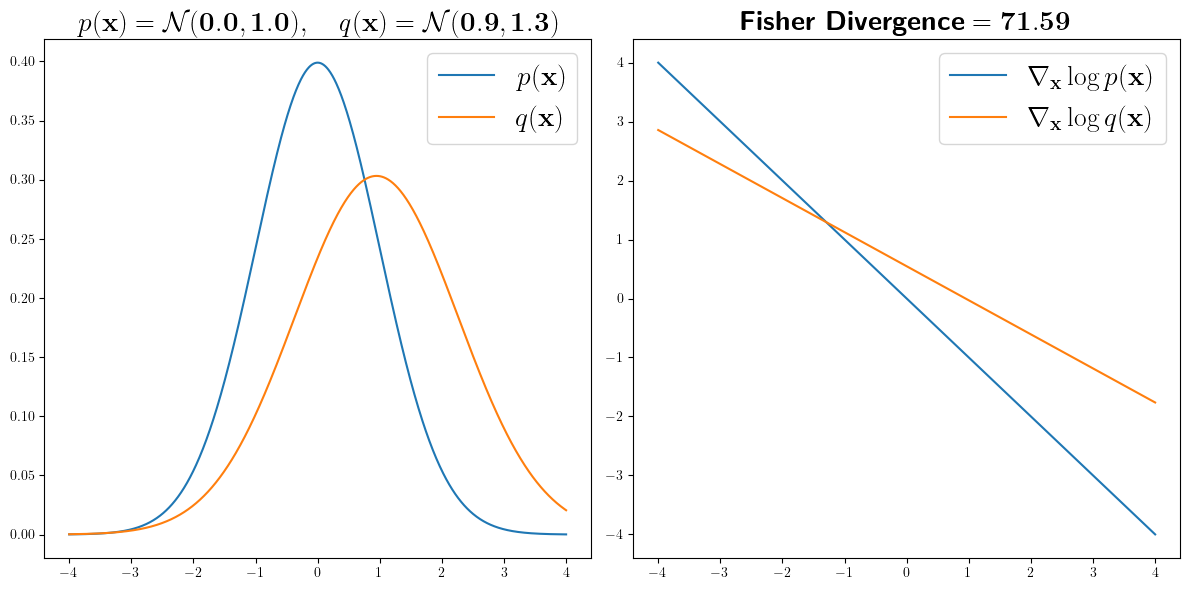

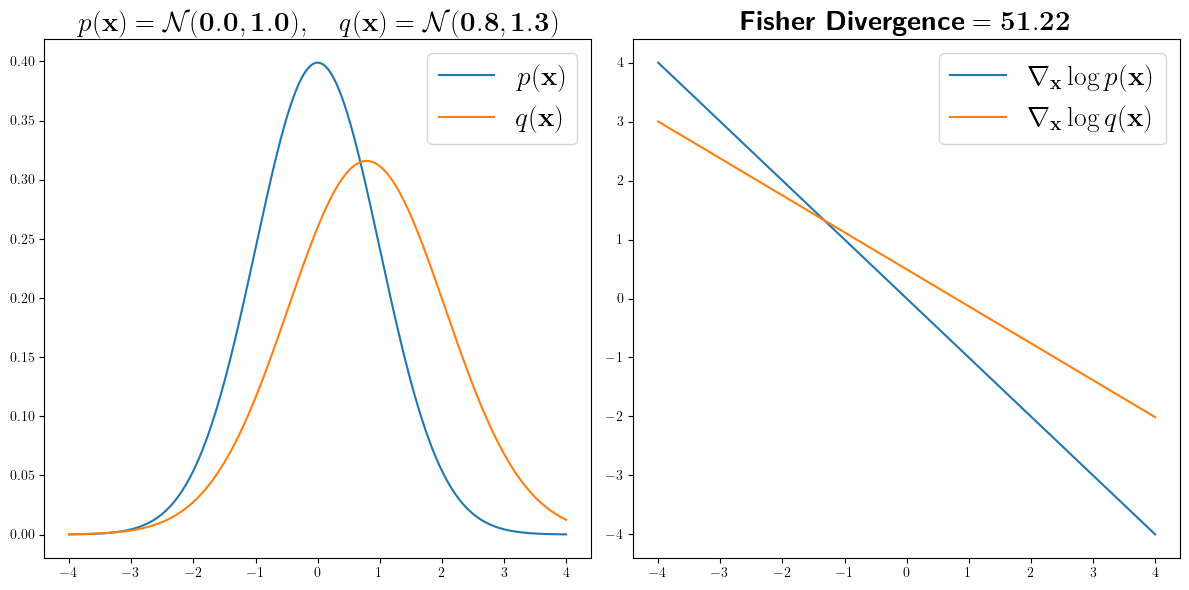

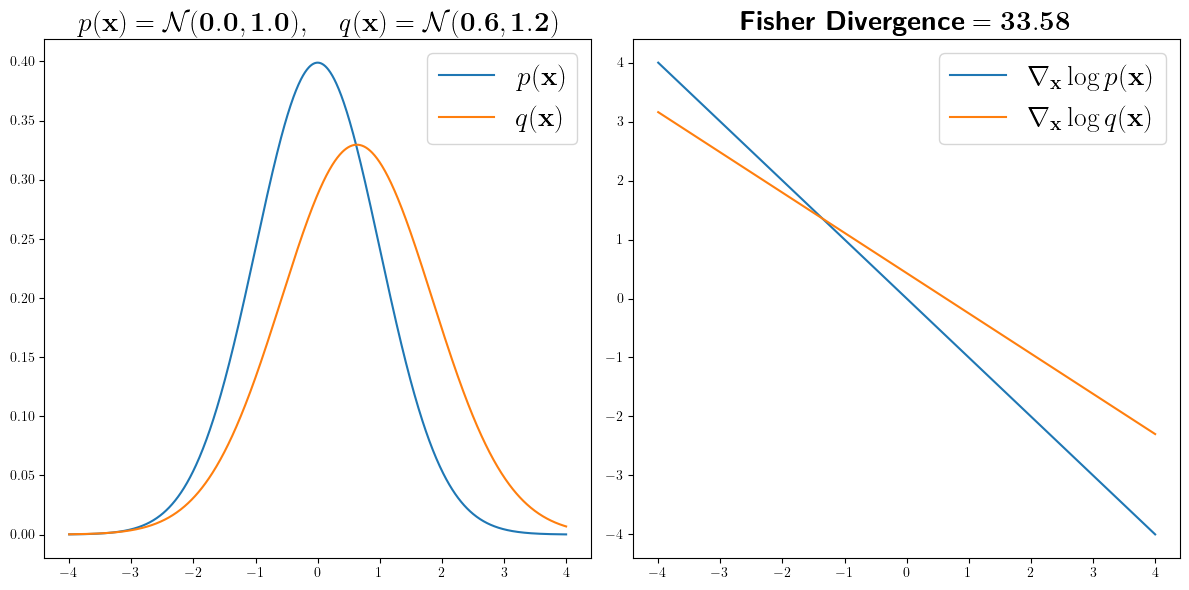

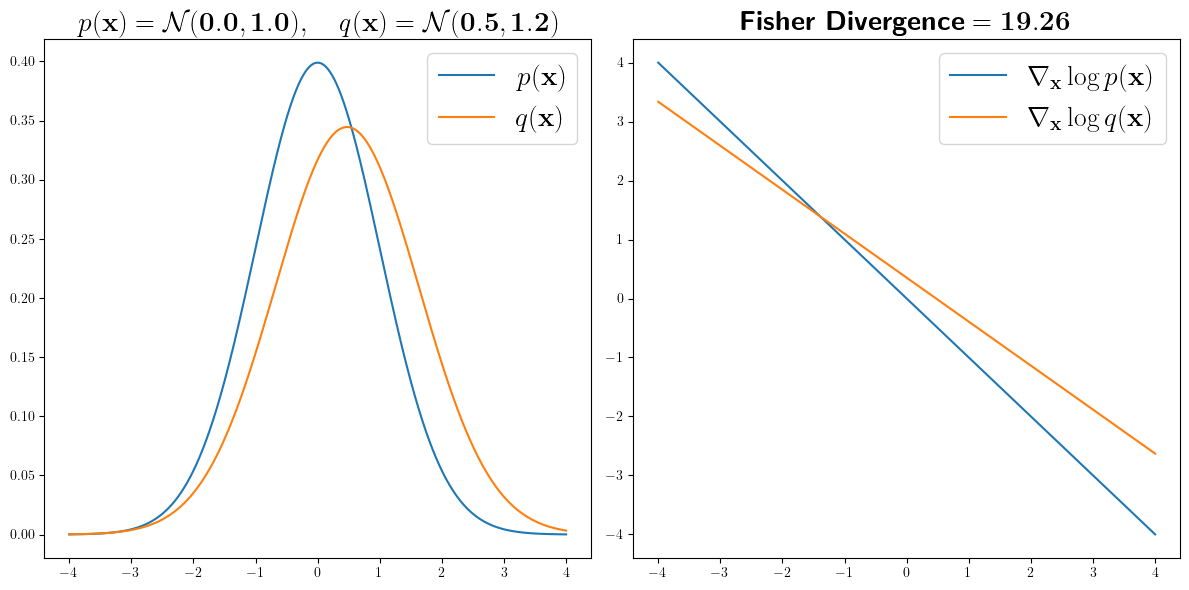

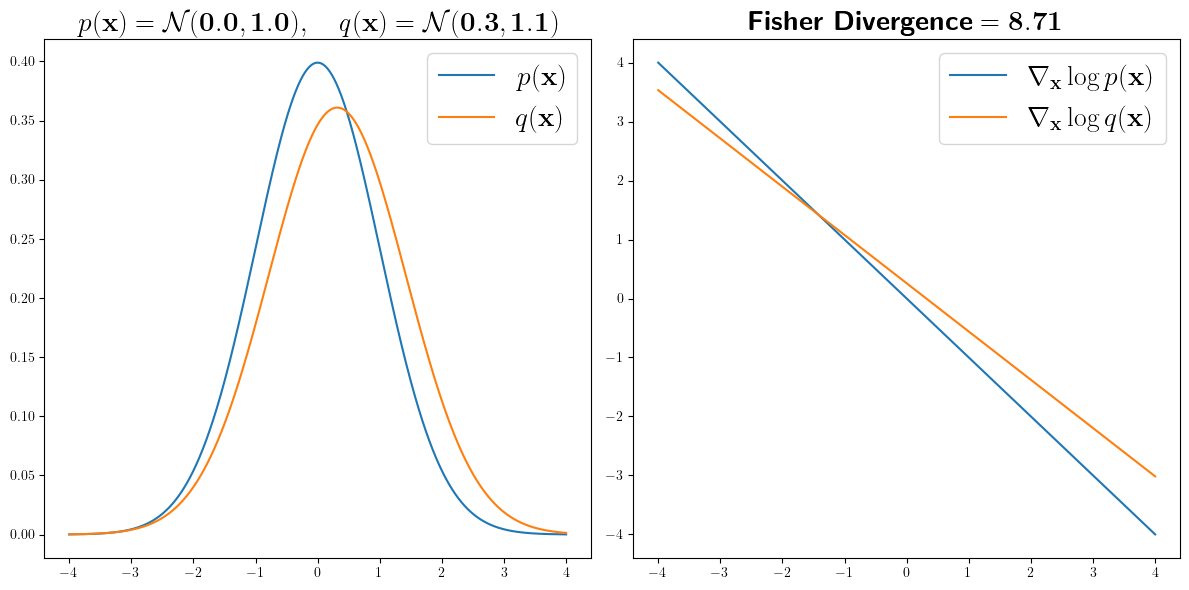

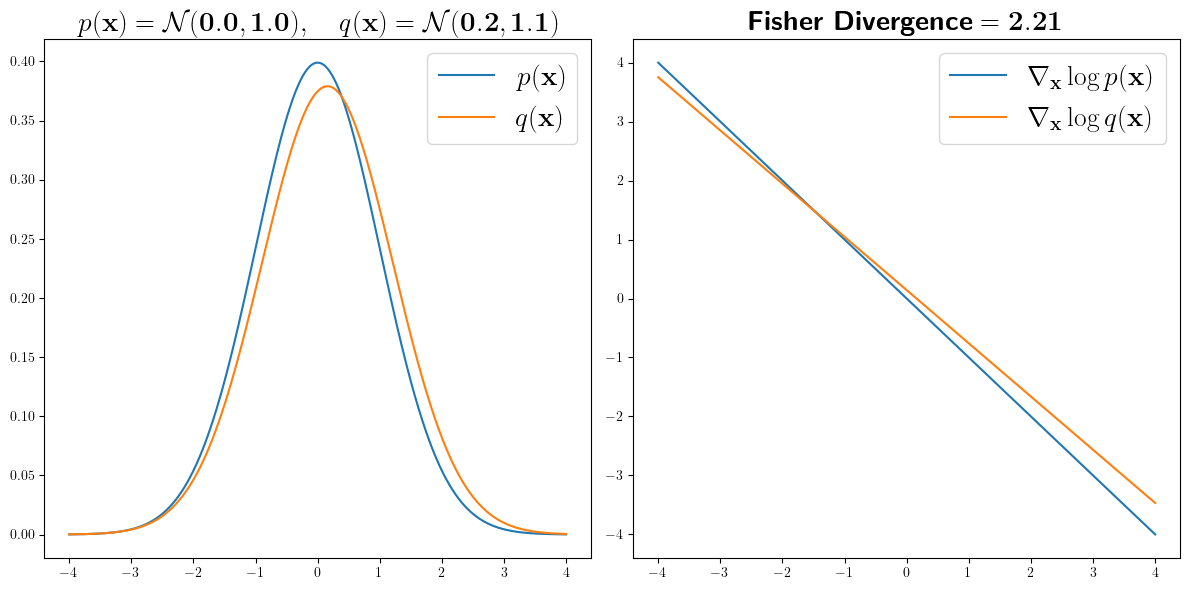

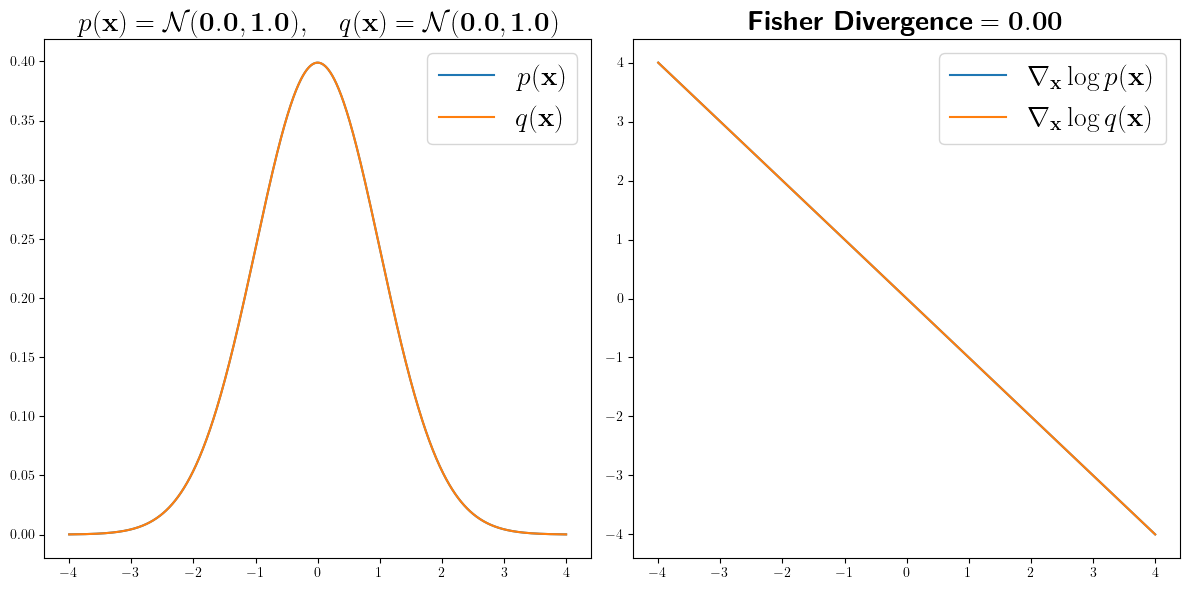

In [4]:
plt.rcParams['text.usetex'] = True

# define a linear range of values between -4 and 4
x = torch.linspace(-4, 4, 1000, requires_grad=True)

p_mu = 0
p_var = 1
q_mus = torch.linspace(3, 0, 20) #[1, 0.6, 0.3, 0]
q_vars = torch.linspace(2, 1, 20) #[3, 2.5, 1.5, 1]

font_size = 20

for t, (q_mu, q_var) in enumerate(zip(q_mus, q_vars[:])):

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # reset gradient to zero
    x.grad = None

    # constant p(x)
    p = gaussian(x, p_mu, p_var)
    log_p = torch.log(p)
    log_p.backward(torch.ones_like(log_p))
    ax2.plot(x.detach().numpy(), x.grad.data, label=r'$\nabla_{\bf{x}} \log p(\bf{x})$')
    deriv_log_p = x.grad.data.clone()

    # reset gradient to zero
    x.grad = None

    # varying q(x)
    q = gaussian(x, q_mu, q_var)
    log_q = torch.log(q)
    log_q.backward(torch.ones_like(log_q))
    ax2.plot(x.detach().numpy(), x.grad.data, label=r'$\nabla_{\bf{x}} \log q(\bf{x})$')
    deriv_log_q = x.grad.data.clone()

    # distance between gradients
    fisher_divergence = 1/2*torch.sum(q * (deriv_log_p - deriv_log_q)**2)

    ax2.set_title(rf'$\textbf{{Fisher Divergence}} = \mathbf{{{fisher_divergence:.2f}}}$', fontdict = {'fontsize' : font_size})
    ax2.legend(fontsize=font_size)

    ax1.plot(x.detach().numpy(), p.detach().numpy(), label=r"$p(\bf{x})$")
    ax1.plot(x.detach().numpy(), q.detach().numpy(), label=r"$q(\bf{x})$")
    ax1.legend(fontsize=font_size)

    ax1.set_title(rf"$p(\bf{{x}}) = \mathcal{{N}}(0.0, 1.0), \quad \mathit{{q}}(\bf{{x}}) = \mathcal{{N}}({q_mu:.1f}, {q_var:.1f})$", fontdict = {'fontsize' : font_size})

    plt.tight_layout()
    plt.savefig(f'../outputs/fisher_example/t-{t}.pdf', dpi=300)

### Load MNIST

In [15]:
import torchvision
import torchvision.transforms as transforms

# define preprocessing transformations to dataset
transform = transforms.Compose([
    # transforms.Resize(32),
    # transforms.Normalize((0.5,), (0.5,)),
    transforms.ToTensor(),
])

# load training set
train_set = torchvision.datasets.MNIST(root="../datasets", train=True, download=True, transform=transform)

# load test/validation set
test_val_set = torchvision.datasets.MNIST(root="../datasets", train=False, download=True, transform=transform)

# split into separate test and validation sets
X_test_val, y_test_val = zip(*test_val_set)
X_test_val = torch.stack(X_test_val)
y_test_val = torch.tensor(y_test_val)

test_idx, val_idx = torch.utils.data.random_split(y_test_val, [5000, 5000])

X_test = X_test_val[test_idx.indices]
y_test = y_test_val[test_idx.indices]

X_val = X_test_val[val_idx.indices]
y_val = y_test_val[val_idx.indices]

(train_set.data.shape, train_set.targets.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([5000, 1, 28, 28]),
 torch.Size([5000]),
 torch.Size([5000, 1, 28, 28]),
 torch.Size([5000]))

### Gaussian Fourier Mapping for time steps $t$

Using [Gaussian Fourier features](https://arxiv.org/abs/2006.10739), we can make coordinate-based neural networks perform better at modeling low dimensions, thereby overcoming the spectral bias. Spectral bias refers to the difficulty of learning high-frequency functions. Specifically, we first sample $\mathbf{\omega} \sim \mathcal{N}(\mathbf{0}, s^2\mathbf{I})$ for a chosen scale $s$. This $\mathbf{\omega}$ is fixed for the model, i.e., not learnable. For a given time step $t$, the corresponding Gaussian random feature is defined as
$$
    \text{GRF}(t) = \text{concat}[\sin(2\pi \omega t); \cos(2\pi \omega t)]
$$

In [16]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim: int, scale: float=30.0):
        super(GaussianFourierProjection, self).__init__()
        # W ~ N(0, scale * I)
        # shape: (embed_size//2, )
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
        
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # X shape: (batch_size, )
        
        # X (batch_size, 1) * W (1, embed_size//2) * 2 pi --> X_proj (batch_size, embed_size//2)
        X_proj = X[:, None] * self.W[None, :] * 2 * np.pi
    
        # output shape: (batch_size, embed_size)
        return torch.cat([torch.sin(X_proj), torch.cos(X_proj)], dim=-1)

batch_size, embed_size = 32, 64 
gfp = GaussianFourierProjection(embed_dim=embed_size)
x = torch.randn(batch_size)
gfp(x).shape

torch.Size([32, 64])

### Linear layer wrapper

Simple wrapper around `nn.Linear` so that we can add two more new dimensions to the output. Broadcasting can then be applied to add the linear transformation to the conv output. 

In [17]:
class LinearUnsqeezed(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(LinearUnsqeezed, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # X shape: (batch_size, input_dim)
        # output shape: (batch_size, output_dim, 1, 1)
        return self.linear(X)[..., None, None]
    
batch_size, inp_dim, out_dim = 8, 32, 4 
dense = LinearUnsqeezed(input_dim=inp_dim, output_dim=out_dim)
x = torch.randn(batch_size, inp_dim)
x.shape, dense(x).shape

(torch.Size([8, 32]), torch.Size([8, 4, 1, 1]))

### Score net



In [18]:
class ScoreNet(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""
    
    def __init__(self, marginal_prob_std, channels: list[int], embed_dim: int):
        """Initialize a time-dependent score-based network.

        Args:
          marginal_prob_std: A function that takes time t and gives the standard
            deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
          channels: The number of channels for feature maps of each resolution.
          embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super(ScoreNet, self).__init__()
        
        self.marginal_prob_std = marginal_prob_std
        
        # Gaussian random feature embedding
        self.embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim), 
            nn.Linear(embed_dim, embed_dim)
        )
        
        # Encoder
        # first encoder block is different from the others
        encoder = [
            nn.ModuleList([
                nn.Conv2d(
                    in_channels=1, 
                    out_channels=channels[0], 
                    kernel_size=3, stride=1, bias=False),
                LinearUnsqeezed(embed_dim, channels[0]),
                nn.GroupNorm(num_groups=4, num_channels=channels[0])
            ])
        ]
        # each block convolves over input, adds linearly mapped gaussian time step feature, and performs group normalization 
        for channel_in, channel_out in zip(channels, channels[1:]):
            group = nn.ModuleList([
                nn.Conv2d(
                    in_channels=channel_in, 
                    out_channels=channel_out, 
                    kernel_size=3, stride=2, 
                    bias=False),
                
                LinearUnsqeezed(input_dim=embed_dim, 
                                output_dim=channel_out),
                
                nn.GroupNorm(num_groups = 32, num_channels=channel_out)
            ])
            encoder.append(group)
        self.encoder = nn.ModuleList(encoder)
        
        # Decoder
        decoder = []
        # last transposed conv layer differs from the rest
        self.last_tconv2d = nn.ConvTranspose2d(
            in_channels=channels[0] + channels[0], 
            out_channels=1, 
            kernel_size=3, stride=1)
        
        for i, (channel_in, channel_out) in enumerate(zip(reversed(channels), reversed(channels[:-1]))):
            
            group = nn.ModuleList([
                nn.ConvTranspose2d(
                    in_channels=channel_in + channel_in if i != 0 else channel_in, 
                    out_channels=channel_out, 
                    kernel_size=3, stride=2, 
                    bias=False,
                    output_padding=1 if i != 0 else 0
                ),
                
                LinearUnsqeezed(input_dim=embed_dim, 
                                output_dim=channel_out),
                
                nn.GroupNorm(num_groups = 32, num_channels=channel_out)
            ])
            decoder.append(group)
        self.decoder = nn.ModuleList(decoder)
        
        # Swish-1 activation function
        self.act = lambda x: x * torch.sigmoid(x)
    
    def forward(self, X: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        
        embedding = self.act(self.embed(t))
        skip_connections = []
        
        # encoder
        for conv, linear, batch_norm in self.encoder:
            X = conv(X)
            X += linear(embedding)
            X = batch_norm(X)
            X = self.act(X)
            skip_connections.append(X.clone())
        
        # decoder (with residual concatenations)
        for i, (H, (conv, linear, batch_norm)) in enumerate(zip(reversed(skip_connections), self.decoder)):
            # no concat if i == 0 because that's just cat([X, X], dim=1)
            X = conv(X if i == 0 else torch.cat([X, H], dim=1))
            X += linear(embedding)
            X = X if batch_norm is None else batch_norm(X)
            X = self.act(X)
        
        X = self.last_tconv2d(torch.cat([X, skip_connections[0]], dim=1))
        
        # normalize by dividing by standard deviation of perturbed X
        y = X / self.marginal_prob_std(t)[:, None, None, None]
        
        return y

# test
net = ScoreNet(lambda x: x, [32, 64, 128, 256], embed_dim=256)
x = torch.randn(64, 1, 28, 28)
t = torch.randn(64,)
net(x, t).shape

torch.Size([64, 1, 28, 28])

### Marginal probability scale

$$
    \sqrt{\dfrac{\sigma^{2t} - 1}{2 \log \sigma}}
$$

In [19]:
import functools

def marginal_prob_std(t: torch.Tensor, sigma: float) -> torch.Tensor:
    return torch.sqrt((sigma ** (2 * t) - 1.0) / 2.0 / np.log(sigma))

def diffusion_coeff(t: torch.Tensor, sigma: float): 
    return sigma**t

sigma = 25
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

$$
    \frac{\sigma^{2t} - 1}{2 \log \sigma} s_{\theta}(\tilde{X}) + Z
$$

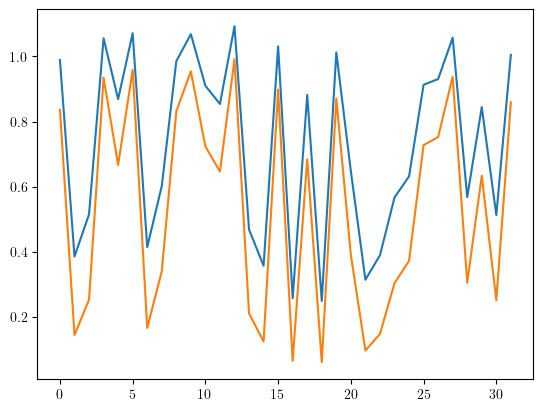

In [20]:
t = torch.rand(32)
m = marginal_prob_std(t, 1.2)

plt.plot(m)
plt.plot(t)


### Loss function

Given mini-batch $X$, perturb via
$$
    \tilde{X}_t = X + \sqrt{\dfrac{\sigma^{2t} - 1}{2 \log \sigma}} Z
$$
where $Z \sim \mathcal{N}(\textbf{0}, \textbf{I})$. The estimate for the gradient of the log data distribution $\nabla_X p_{\text{data}}(X)$ is given by
$$
    s_{\mathbf{\theta}}(X_t, t)
$$
and parameterized by a U-net. The loss is then
$$
    \mathbb{E}_{t \sim \mathcal{U}(0, T)} \mathbb{E}_{X \sim p_t(X)}\left[\left(Z + s_{\mathbf{\theta}}(X_t, t) \sqrt{\dfrac{\sigma^{2t} - 1}{2 \log \sigma}}\right)^2\right]
$$

In [25]:
def loss_fn2(model: nn.Module, X: torch.Tensor, marginal_prob_std, eps: float=1e-5) -> torch.Tensor:
    
    batch_size = X.shape[0]
    random_t = torch.rand(batch_size).to(X.device)
    Z = torch.randn_like(X)
    std = marginal_prob_std(random_t)
    
    perturbed_X = X + Z * std[:, None, None, None]
    score = model(perturbed_X, random_t)
    
    loss = torch.sum((score * std[:, None, None, None] + Z)**2, dim=(1, 2, 3)).mean()
    return loss

def loss_fn(model: nn.Module, X: torch.Tensor, marginal_prob_std, eps: float=1e-5) -> torch.Tensor:

    batch_size = X.shape[0]
    random_t = torch.rand(batch_size).to(X.device)
    Z = torch.randn_like(X)
    std = marginal_prob_std(random_t)

    perturbed_X = X + Z * std[:, None, None, None]
    score = model(perturbed_X, random_t)

    loss = torch.sum((score + Z/std[:, None, None, None])**2, dim=(1, 2, 3)).mean()

    # loss = torch.sum((score * std[:, None, None, None] + Z)**2, dim=(1, 2, 3)).mean()
    return loss

In [26]:
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 1e-4
EMBED_DIM = 256
CHANNELS = [32, 64, 128, 256]

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
from torch.utils.data import DataLoader

data_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

model = ScoreNet(
    marginal_prob_std=marginal_prob_std_fn, 
    channels=CHANNELS,
    embed_dim=EMBED_DIM
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

training_loss = []


In [28]:

for epoch in range(EPOCHS):

    batch_loss, n_items = 0, 0
    for X, y in data_loader:
        X = X.to(DEVICE)
        
        loss = loss_fn(model, X, marginal_prob_std_fn)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss += loss.item() * X.shape[0]
        n_items += X.shape[0]
        
    training_loss.append(batch_loss / n_items)
    print(f"Epoch: {epoch}\tTraining loss: {training_loss[-1]:.4f}")
    
plt.plot(training_loss)

KeyboardInterrupt: 

In [15]:
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           batch_size=64, 
                           num_steps=500, 
                           device='cuda', 
                           eps=1e-3):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns:
    Samples.    
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  
  diffused_X = []
  with torch.no_grad():
      for time_step in time_steps:      
          batch_time_step = torch.ones(batch_size, device=device) * time_step
          g = diffusion_coeff(batch_time_step)
          mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
          x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
          diffused_X.append(mean_x)
    
  # Do not include any noise in the last sampling step.
  return mean_x, diffused_X

In [20]:
x_sample, diffused_x = Euler_Maruyama_sampler(model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size=BATCH_SIZE, num_steps=1000, device=DEVICE, eps=1e-3)

x_sample.shape, len(diffused_x)

(torch.Size([32, 1, 28, 28]), 1000)

In [23]:
1000/25

40.0

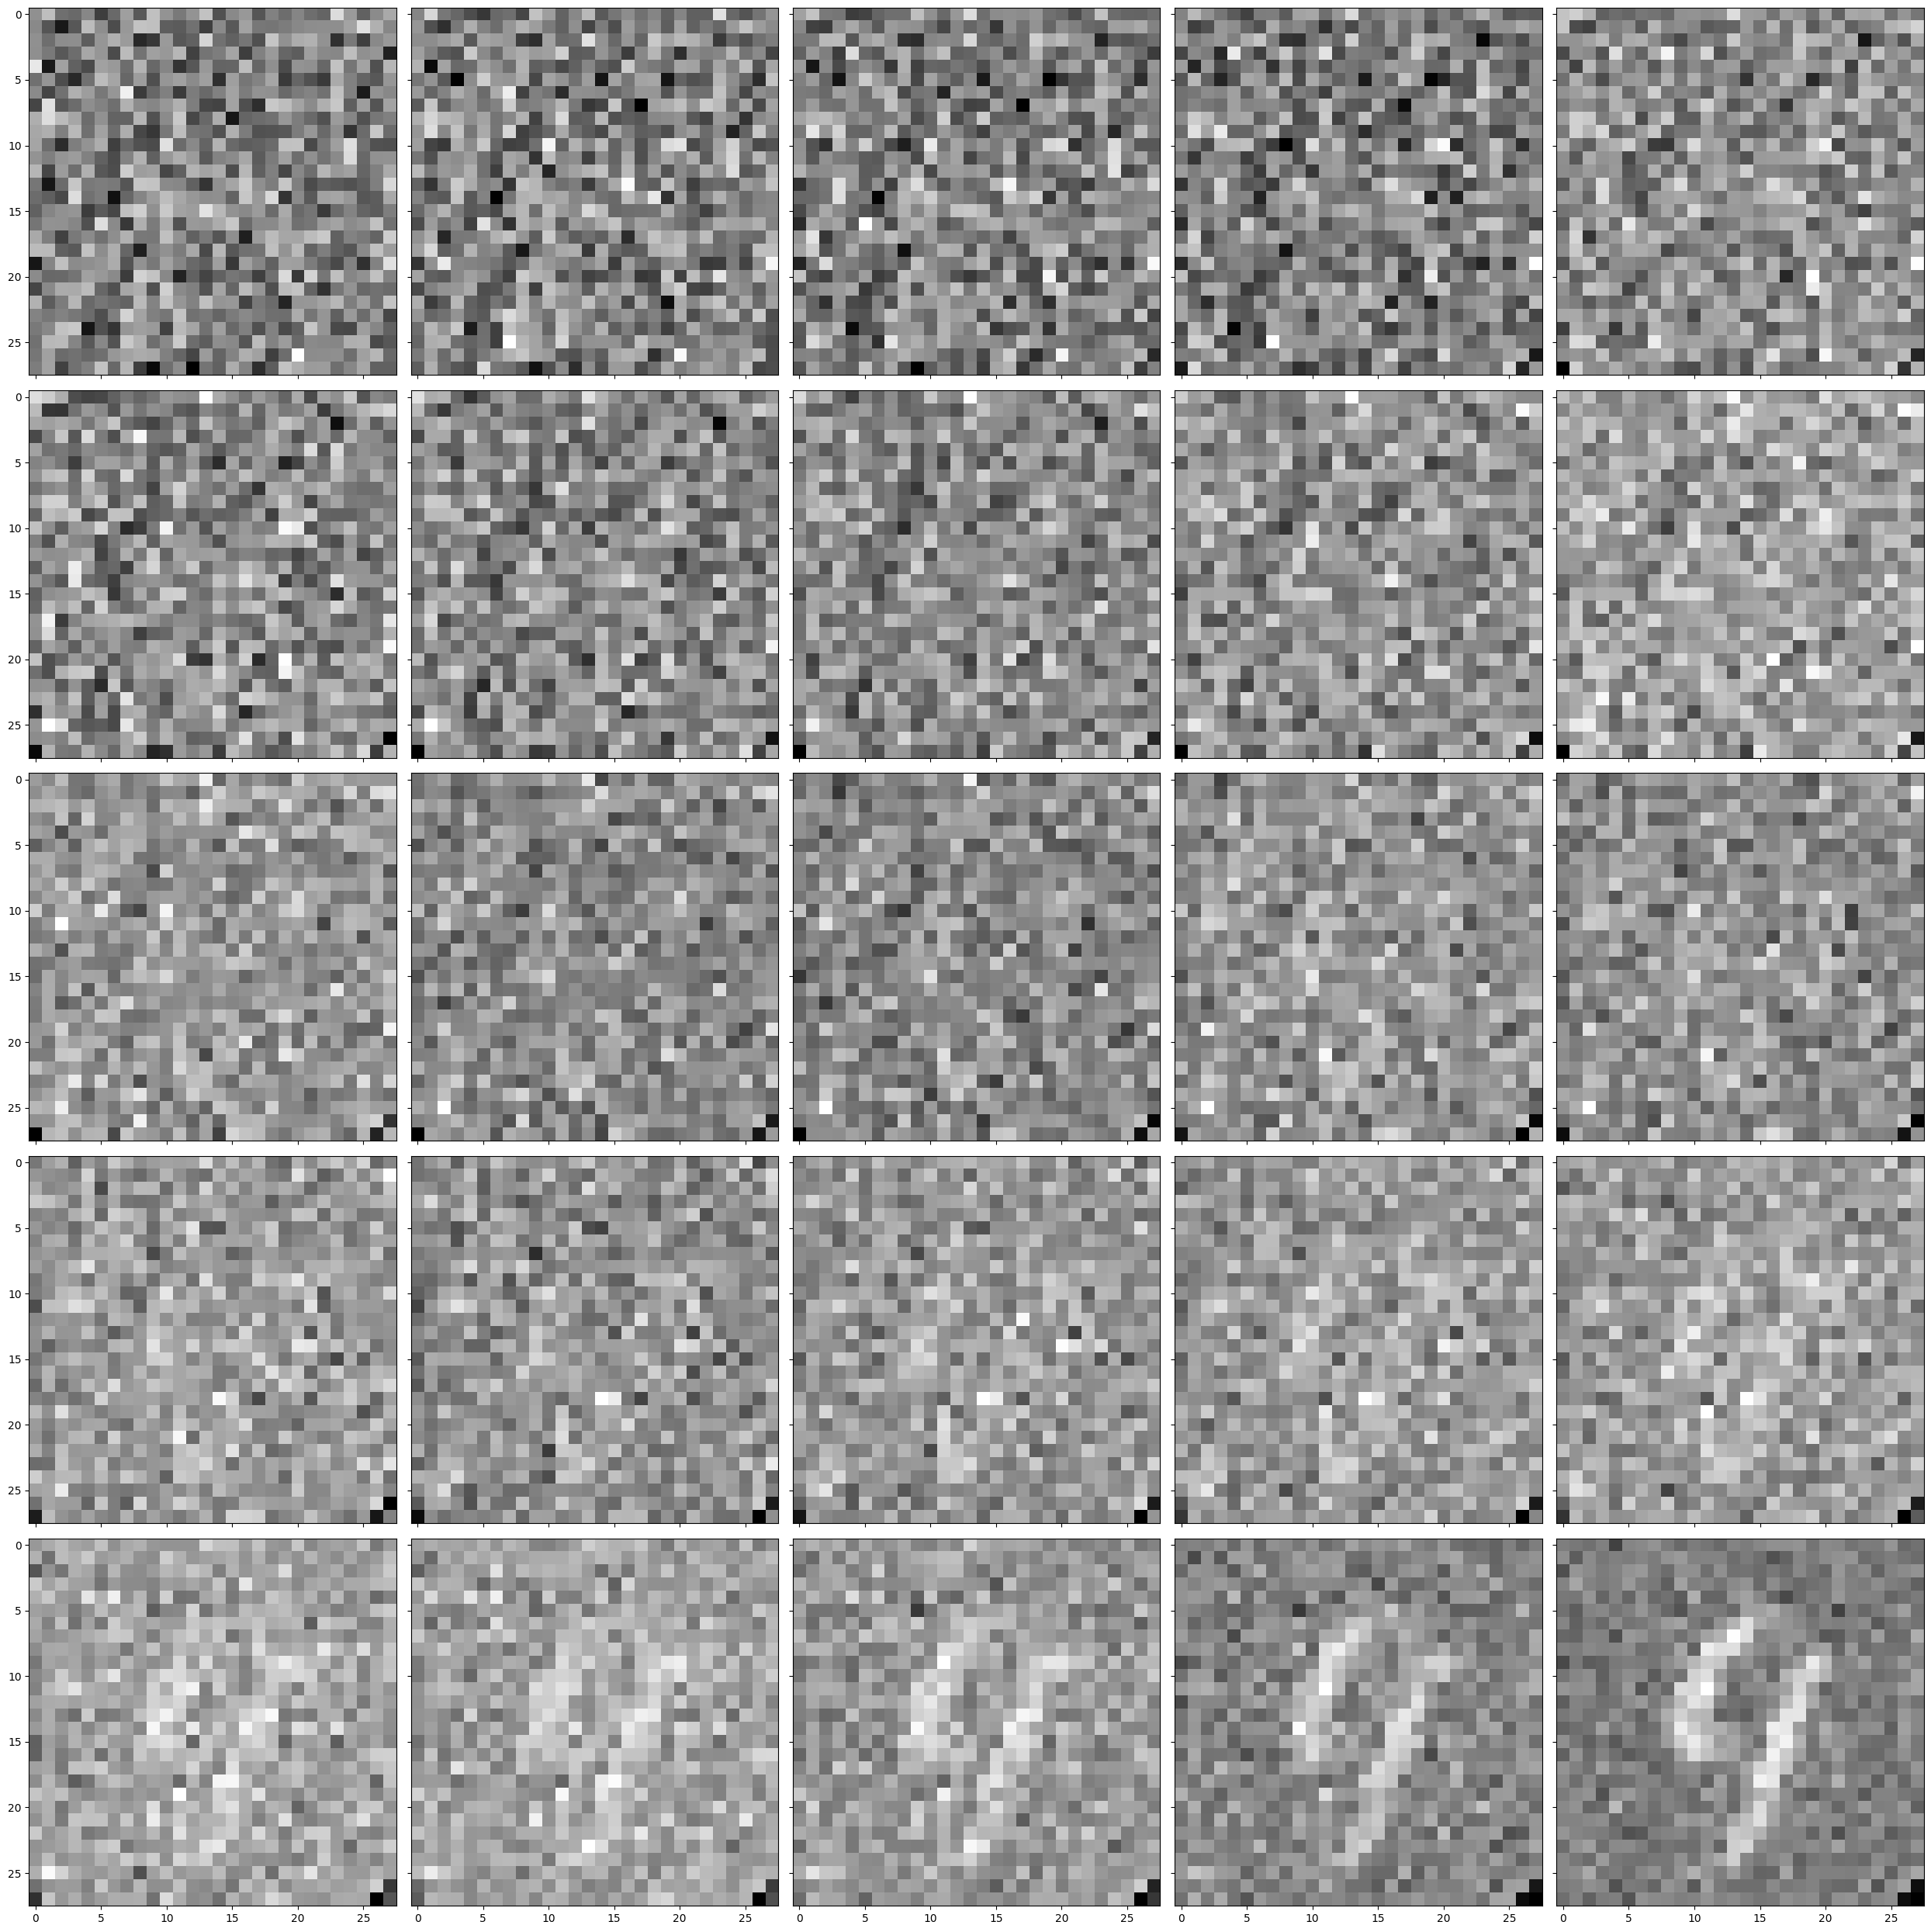

In [27]:
_, axes = plt.subplots(5, 5, figsize=(25, 25), sharex=True, sharey=True)
axes = axes.flatten()

for ax, diff_x in zip(axes, diffused_x[::40]):
    ax.imshow(diff_x[11, 0].cpu().numpy(), cmap='gray')

plt.tight_layout()

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1000x1000', '-pix_fmt', 'rgba', '-framerate', '60', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '../outputs/scorenet_diffusion_process.mp4']' returned non-zero exit status 255.

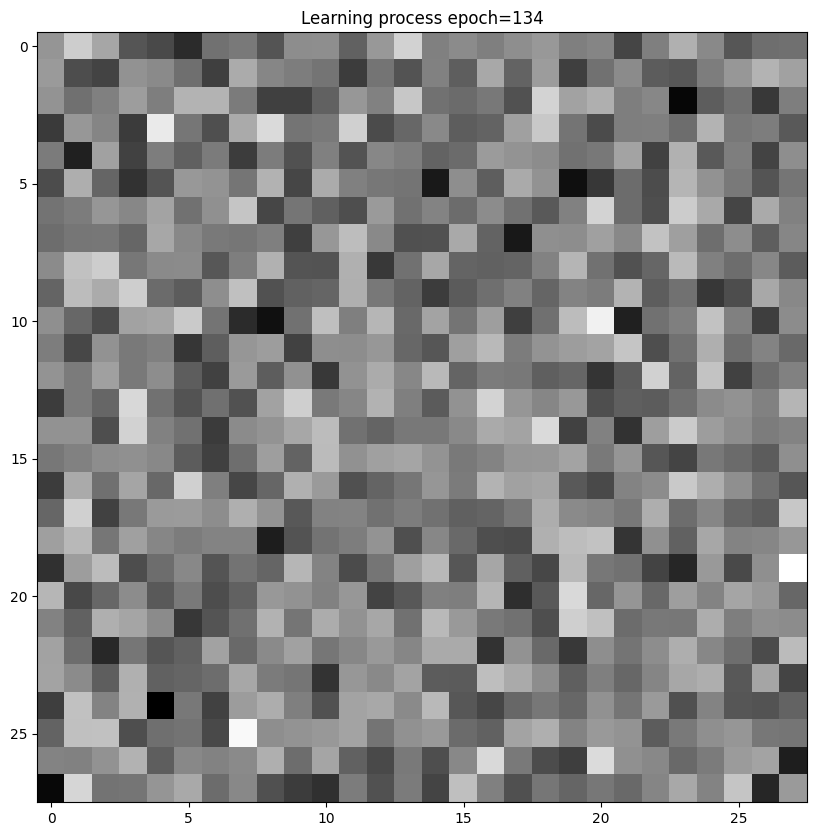

In [28]:
from matplotlib import animation

fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
# ax.set_xlabel(r'$h_1$')
# ax.set_ylabel(r'$h_2$')
# sc = ax.scatter([], [])

def animate(i):
    # global sc
    ax.imshow(diffused_x[i][11, 0].cpu().numpy(), cmap='gray')
    ax.set_title(f'Learning process epoch={i}')
    return 

anim = animation.FuncAnimation(fig, animate, frames=len(diffused_x), repeat=False, interval=10)
anim.save('../outputs/scorenet_diffusion_process.mp4', writer=animation.FFMpegWriter(fps=60))

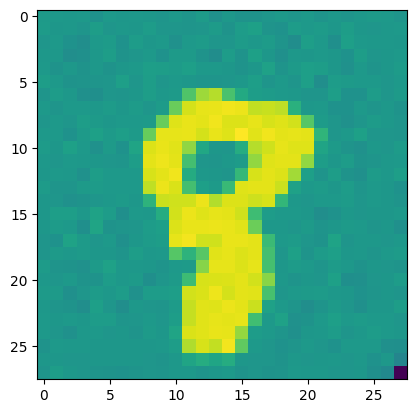

In [236]:
plt.imshow(x_sample[6, 0].cpu().numpy())